<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/llr_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 1.5.1+cu101
CUDA enabled: False


In [ ]:
USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device:', device)

Using device: cpu


In [ ]:
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import timeit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Data Loaders

##### MNIST2

In [ ]:
import torchvision
from torchvision import transforms, datasets

train_data = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.MNIST('', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Processing
Done!
Files already downloaded


In [ ]:
MNIST_CUTOFF = 64

idx0 = train_data.train_labels==0
idx1 = train_data.train_labels==1
idx = []
counter = 0
for val1, val2 in zip(idx0.numpy(), idx1.numpy()):
    if val1 or val2:
        idx.append(counter)
    counter += 1
    
# cuts off idx after certain number of values    
idx = idx[0:MNIST_CUTOFF]
print("Cutting off train set at:", len(idx))
    
train_data_subset = torch.utils.data.Subset(train_data, idx)
trainset = torch.utils.data.DataLoader(train_data_subset, batch_size=MNIST_CUTOFF, shuffle=True)

idx0 = test_data.test_labels==0
idx1 = test_data.test_labels==1
idx = []
counter = 0
for val1, val2 in zip(idx0.numpy(), idx1.numpy()):
    if val1 or val2:
        idx.append(counter)
    counter += 1
    
# cuts off idx after certain number of values    
idx = idx[0:MNIST_CUTOFF]
print("Cutting off test set at:", len(idx))
    
test_data_subset = torch.utils.data.Subset(test_data, idx)
testset = torch.utils.data.DataLoader(test_data_subset, batch_size=MNIST_CUTOFF, shuffle=True)

Cutting off train set at: 64
Cutting off test set at: 64


In [ ]:
# This is ordered in a funny way, so this function reorders the indices within a batch
def reorder_mnist(dataset):
    mnist_batch = next(iter(dataset))
    X_mnist = []
    y_mnist = []
    for i in range(MNIST_CUTOFF):
        X_mnist.append(mnist_batch[0][i].tolist())
        y_mnist.append(mnist_batch[1][i].tolist())
    X_tensor = torch.tensor(X_mnist).view(MNIST_CUTOFF, 28*28)
    y_tensor = torch.tensor(y_mnist)
    return X_tensor, y_tensor

In [ ]:
# This displays a few MNIST images, which should all be 0s and 1s
counter = 0
print(next(iter(trainset))[1][68])
for train_vals in trainset:
    X, y = train_vals[0][127], train_vals[1][127]
    print(X.size())
    print(y)
    plt.imshow(X.view(28,28))
    plt.show()
    counter += 1
    if counter == 3:
        break

##### CIFAR2

In [ ]:
import torchvision
from torchvision import transforms, datasets

train_data = datasets.CIFAR10(root='./CIFAR2', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.CIFAR10(root='./CIFAR2', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
CIFAR_CUTOFF = 64

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

idx0 = torch.tensor(train_data.train_labels) == 0 # planes
idx1 = torch.tensor(train_data.train_labels) == 1 # cars
idx = []
counter = 0
for val1, val2 in zip(idx0.numpy(), idx1.numpy()):
    if val1 or val2:
        idx.append(counter)
    counter += 1
    
# cuts off idx after certain number of values    
idx = idx[0:CIFAR_CUTOFF]
print("Cutting off train set at:", len(idx))
    
train_data_subset = torch.utils.data.Subset(train_data, idx)
trainset = torch.utils.data.DataLoader(train_data_subset, batch_size=CIFAR_CUTOFF, shuffle=True)

idx0 = torch.tensor(test_data.test_labels) == 0 # planes
idx1 = torch.tensor(test_data.test_labels) == 1 # cars
idx = []
counter = 0
for val1, val2 in zip(idx0.numpy(), idx1.numpy()):
    if val1 or val2:
        idx.append(counter)
    counter += 1
    
# cuts off idx after certain number of values    
idx = idx[0:CIFAR_CUTOFF]
print("Cutting off test set at:", len(idx))
    
test_data_subset = torch.utils.data.Subset(test_data, idx)
testset = torch.utils.data.DataLoader(test_data_subset, batch_size=CIFAR_CUTOFF, shuffle=True)

Cutting off train set at: 64
Cutting off test set at: 64


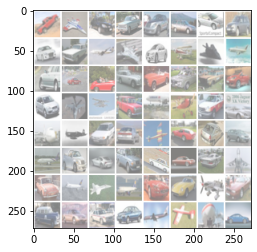

  car plane   car   car


In [ ]:
# This displays a few CIFAR images, which should all be planes and cars
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainset)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# This is ordered in a funny way, so this function reorders the indices within a batch
def reorder_cifar(dataset):
    cifar_batch = next(iter(trainset))
    X_cifar = []
    y_cifar = []
    for i in range(CIFAR_CUTOFF):
        X_cifar.append(cifar_batch[0][i].tolist())
        y_cifar.append(cifar_batch[1][i].tolist())
    X_tensor = torch.tensor(X_cifar).view(CIFAR_CUTOFF, 32*32*3)
    y_tensor = torch.tensor(y_cifar)
    return X_tensor, y_tensor

#### Core Code

##### Network Definition

In [ ]:
class Net(nn.Module):
    def __init__(self, width, length, activation, input_dim, BIAS=False, const_w=False):
        super().__init__()
        self.width = width
        self.length = length
        self.input_dim = input_dim
        
        if INPUT_CONST:
#             self.in_const = nn.Linear(self.input_dim, self.input_dim, bias=True)
#             self.in_const.weight = torch.eye(self.input_dim)
#             nn.init.normal_(self.in_const.bias, mean=0.0, std=1.0)
            self.in_const = nn.Parameter(torch.empty(1,1).normal_(0.0, 1.0))

        self.fc_u = nn.Linear(input_dim, self.width, bias=BIAS)
        if V_BIAS:
            self.fc_v = nn.Linear(self.width, 1, bias=True)
            # since we multiply by 1/sqrt(n), need to initialize \sqrt(n) times bigger
            nn.init.normal_(self.fc_v.bias, mean=0.0, std=np.sqrt(self.width))
        else:
            self.fc_v = nn.Linear(self.width, 1, bias=BIAS)

        # Initializes weights to N(0,1) (default is Xavier)
        nn.init.normal_(self.fc_u.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc_v.weight, mean=0.0, std=1.0)
        if BIAS:
            nn.init.normal_(self.fc_u.bias, mean=0.0, std=np.sqrt(self.width))
            nn.init.normal_(self.fc_v.bias, mean=0.0, std=np.sqrt(self.width))
        
        if self.length > 1:
            self.fc_w1 = nn.Linear(self.width, self.width, bias=BIAS)
            if const_w:
#                 print('Holding W const')
                self.fc_w1.weight.requires_grad = False
            nn.init.normal_(self.fc_w1.weight, mean=0.0, std=1.0)
            if BIAS:
                nn.init.normal_(self.fc_w1.bias, mean=0.0, std=np.sqrt(self.width))
        if self.length > 2:
            self.fc_w2 = nn.Linear(self.width, self.width, bias=BIAS)
            nn.init.normal_(self.fc_w2.weight, mean=0.0, std=1.0)
            if BIAS:
                nn.init.normal_(self.fc_w2.bias, mean=0.0, std=self.np.sqrt(self.width))
        
        if activation == 'Linear':
            self.act = nn.Identity()
        elif activation == 'ReLU':
            self.act = nn.ReLU()
        elif activation == 'Tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError('Activation not implemented!')
                                   
    def forward(self, x):
#         print('Bias:', self.in_const)
#         print('Raw in:', x)
        if INPUT_CONST:
            x = x - self.in_const
#         print('In with bias', x)
        x = self.fc_u(x)
        x = self.act(1 / np.sqrt(self.input_dim) * x)
#         x = self.act(x)
        if self.length > 1:
            x = self.fc_w1(x)
            x = self.act(1 / np.sqrt(self.width) * x)
        if self.length > 2:
            x = self.fc_w2(x)
            x = self.act(1 / np.sqrt(self.width) * x)
        x = self.fc_v(x)
        return 1 / np.sqrt(self.width) * x        

##### NTK Function

In [ ]:
def ntk_auto(x, net, NTRAIN):
    ntk_val = np.zeros((NTRAIN, NTRAIN))

    GRAD_FIRST = True
    
    if GRAD_FIRST: # Calculates all gradients first, this might not work for large datasets
        outs = []
        grads = []
        for sample in range(x.size()[0]): # iterate over batch index
            out_for_sample = net(x[sample,:])
            outs.append(out_for_sample)
            
            grads_for_sample = []
            for param_it in range(len(list(net.parameters()))):
                if list(net.parameters())[param_it].requires_grad: # only accesses gradients if they are calculated
                    grad_val = torch.flatten(torch.autograd.grad(out_for_sample, list(net.parameters())[param_it], retain_graph=True)[0])
                    grads_for_sample.append(grad_val)
            grads.append(grads_for_sample)
            
         # Calculation of ntk using gradients
        for sample1 in range(0, x.size()[0]): # iterate over batch index
            out1 = outs[sample1]
            for sample2 in range(0, x.size()[0]):
                out2 = outs[sample2]
                
                if sample1 > sample2: # NTK is symmetric, so doesn't recalculate these
                    ntk_val[sample1][sample2] = ntk_val[sample2][sample1]
                else:
                    for param_it in range(len(list(net.parameters()))):
                        if list(net.parameters())[param_it].requires_grad: # only adds if gradient is calculated
                            grads1 = grads[sample1][param_it]
                            grads2 = grads[sample2][param_it]
                            ntk_val[sample1][sample2] += torch.matmul(grads1, grads2).cpu().data.numpy()
    
    else: # Calculate gradients in real time, this is less efficient
        for sample1 in range(0, x.size()[0]): # iterate over batch index
            out1 = net(x[sample1,:])
            for sample2 in range(0, x.size()[0]):
                out2 = net(x[sample2,:])

                if sample1 > sample2: # NTK is symmetric, so doesn't recalculate these
                    ntk_val[sample1][sample2] = ntk_val[sample2][sample1]
                else:
                    for param_it in range(len(list(net.parameters()))):
                        grads1 = torch.autograd.grad(out1, list(net.parameters())[param_it], retain_graph=True)
                        grads2 = torch.autograd.grad(out2, list(net.parameters())[param_it], retain_graph=True)
                        ntk_val[sample1][sample2] += torch.matmul(torch.flatten(grads1[0]),torch.flatten(grads2[0])).cpu().data.numpy()

    ntk_val = 1/NTRAIN * ntk_val
#     print('ntk_val auto2:', ntk_val)
    return ntk_val

##### Training

In [ ]:
def train(train_data, lr_init, WIDTH, EPOCHS, TRIALS, length=1, ACT='Linear', NTRAIN=1, INPUT_DIM=1, 
          OUTPUTS=1, LOSS='L1', VAR_LR=False, const_w=False):
    
    # Unpacks train_data
    X, y = train_data[:][0], train_data[:][1]
    
    # Number of training steps
    steps = int(NTRAIN/BATCH_SIZE) * EPOCHS
        
    train_outputs = dict()
    
    fs = np.zeros((TRIALS, steps, NTRAIN))
    ntks = np.zeros((TRIALS, steps, NTRAIN, NTRAIN))
    losses = np.zeros((TRIALS, steps))
    order_param = np.zeros((TRIALS, steps))
    max_cond = np.zeros((TRIALS, steps))
    dead_neurons = np.zeros((TRIALS, steps))
    eta_catas = np.zeros(TRIALS)
    angle = np.zeros((TRIALS, steps))
    dec_bdry1 = np.zeros((TRIALS, steps)) # angle of db
    dec_bdry2 = np.zeros((TRIALS, steps)) # fns mag
    dec_bdry3 = np.zeros((TRIALS, steps)) # fs mag
    dec_bdry4 = np.zeros((TRIALS, steps)) # ui1ui2 mag
    
    lprime_ns = np.zeros((TRIALS, steps))
    lprime_s = np.zeros((TRIALS, steps))
    Theta_ns = np.zeros((TRIALS, steps))
    Theta_s = np.zeros((TRIALS, steps))    

    SINGULAR_VALUES = 3
    sv_vals = np.zeros((TRIALS, steps, SINGULAR_VALUES))
    ntk_comp_mags = np.zeros((TRIALS, steps, length + 1))
    align_angles = np.zeros((TRIALS, steps, length + 1))
    id_diff = np.zeros((TRIALS, steps, 6)) # difference from the identity: 0: mean, 1: max, 2: 3/4, 3: median, 4: 1/4, 5: min
    
    if length == 1:
        weight_mags = np.zeros((TRIALS, steps, 2)) # both weights
    elif length == 2:
        weight_mags = np.zeros((TRIALS, steps, 5)) # all 3 weights plus vW and Wu
    
    if LOSS == 'CE2' and NTRAIN != 2:
            raise ValueError("NTRAIN should be 2 for Loss=CE2")
    elif LOSS == 'CE4' and NTRAIN != 4:
            raise ValueError("NTRAIN should be 4 for Loss=CE4")

#     for trial in tqdm(range(TRIALS)):
    for trial in range(TRIALS):
        
        net = Net(WIDTH, length, ACT, INPUT_DIM, BIAS=BIAS, const_w=const_w).to(device)
        optimizer = optim.SGD(net.parameters(), lr=lr_init)
        # Finds direction of (unit) eigenvector of ntk with largest eigenvalue
        # ntk_init = ntk(weights_init, x)
        # eigval, eigvec = np.linalg.eig(ntk_init)
        # eig_max_idx = np.argmax(eigval)
        # eig_max = eigvec[eig_max_idx]
        
        lr_t = lr_init

        for epoch in range(EPOCHS):
            for batch in range(0, len(X), BATCH_SIZE):
                
                step = int(NTRAIN/BATCH_SIZE) * epoch + batch
                
                batch_X = X[batch:batch + BATCH_SIZE]
                batch_y = y[batch:batch + BATCH_SIZE]
                                   
                net.zero_grad()

                output = net(batch_X)

                f = output.data.cpu().numpy()[:,0]

                # Finds losses and dL/df (lprime) for various losses
                if LOSS == 'MSE':
                    y_val = [val[0] for val in batch_y.cpu().data.numpy()]
                    # MSE loss is (f(x)-y)^2 so need np.sqrt(2) in order to map to 1/2*(f(x)-y)^2
                    loss = F.mse_loss(1/np.sqrt(2)*output, 1/np.sqrt(2)*batch_y, reduction='mean')
                    lprime = 1/NTRAIN * (f-y_val)
                elif LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
                    y_val = batch_y.cpu().data.numpy()[:]
                    out = torch.stack([-1/2 * output.view(BATCH_SIZE), 1/2 * output.view(BATCH_SIZE)], dim=1)
                    loss = F.cross_entropy(out, batch_y)
                    lprime = np.zeros(BATCH_SIZE)
                    for sample in range(BATCH_SIZE):
                        out = f[sample]
                        if batch_y[sample] == 0:
                            lprime[sample] = 1/NTRAIN * 1/(1+np.exp(-out))
                        elif batch_y[sample] == 1:
                            lprime[sample] = -1/NTRAIN * 1/(1+np.exp(out))
                    lprime_mse = 1/NTRAIN * (f-y_val)
                elif LOSS == 'L1':
                    y_val = batch_y.data.numpy()[:,0]
                    loss = F.l1_loss(output, batch_y)
                    lprime = 1/BATCH_SIZE * np.sign(f-y_val)
                else:
                    raise ValueError("Loss not implemented")

                loss.backward()

                # Variable Learning Rate
                if VAR_LR:
                  # Amount the learning_rate should be adjusted
                  val = np.sum(lprime_mse)/np.sum(lprime)
                  adjust_learning_rate(optimizer, lr_init, val)

                ntk_array = ntk_auto(X, net, NTRAIN) 
                with torch.no_grad(): # doesn't track gradients through below calculations
                    ########## Dead Neuron Calculation ##########
                    if ACT == 'ReLU' and length == 1:
                        u = net.fc_u.weight.data.view(WIDTH, INPUT_DIM)
                        for sample in range(batch_X.size()[0]):
                            ones_array = np.ones(WIDTH)
                            num_alive = np.sum(ones_array[torch.matmul(u, batch_X[sample])>0])
                            dead_neuron_perc = 1 - 1/WIDTH * num_alive
                            dead_neurons[trial][step] += 1/BATCH_SIZE * dead_neuron_perc
                    if length == 1 and ACT == 'Linear':
                        v_mag = np.linalg.norm(net.fc_v.weight.data.cpu().numpy()[0,:])
                        u_mag = np.linalg.norm(net.fc_u.weight.data.cpu().numpy()[:,0])
                        if v_mag == 0 or u_mag == 0:
                            angle[trial][step] = 0
                        elif NTRAIN == 1:
                            angle[trial][step] = np.sqrt(WIDTH) * f / (v_mag*u_mag)
                        elif NTRAIN == 2:
                            angle[trial][step] = np.sqrt(WIDTH) * f[0] / (v_mag*u_mag)
                        if f[0] == 0: # 2 here because NTK elements are 1/2*\lambda
                            order_param[trial][step] = 2*ntk_array[0][0] * 1/4
                        else:
                            order_param[trial][step] = 2*ntk_array[0][0] * 1/2 * np.tanh(f[0]/2) / f[0]
                    ########## Decision Boundary Calculations ##########
                    TRACK_DB = False
                    if TRACK_DB:
                        if INPUTS == 1 and not INPUT_CONST:
                            bias_val = net.fc_v.bias.data.cpu().numpy()[0]/np.sqrt(WIDTH)
                            ui = net.fc_u.weight.data.cpu().numpy()[:,0]
                            vi = net.fc_v.weight.data.cpu().numpy()[0]
                            f_s = 1/np.sqrt(WIDTH) * np.dot(ui, vi)
                            f_ns = f_s + bias_val
                            fprime_val = f[0] - bias_val
                            dec_bdry1[trial][step] = bias_val
                            dec_bdry2[trial][step] = np.abs(f_ns)
                            dec_bdry3[trial][step] = np.abs(f_s)
                            dec_bdry4[trial][step] = -1 * bias_val / f_s
                        if INPUTS == 1 and INPUT_CONST:
                            bias_val = net.in_const.data.cpu().numpy()[0]
#                             print('Bias:', bias_val)
                            ui = net.fc_u.weight.data.cpu().numpy()[:,0]
                            vi = net.fc_v.weight.data.cpu().numpy()[0]
                            f_s = 1/np.sqrt(WIDTH) * np.dot(ui, vi)
                            f_ns = f_s * (1 - bias_val)
                            dec_bdry1[trial][step] = bias_val
                            dec_bdry2[trial][step] = np.abs(f_ns)
                            dec_bdry3[trial][step] = np.abs(f_s)
                            dec_bdry4[trial][step] = bias_val
                        elif INPUTS == 2: 
                            out1 = net(torch.tensor([[1.0, 0.0]]).view(1, 2).to(device))
                            f1 = out1.data.cpu().numpy()[0,0]
                            out2 = net(torch.tensor([[0.0, 1.0]]).view(1, 2).to(device))
                            f2 = out2.data.cpu().numpy()[0,0]
                            dec_bdry1[trial][step] = np.arctan2(f2, f1)
                            ui1 = net.fc_u.weight.data.cpu().numpy()[:,0]
                            ui2 = net.fc_u.weight.data.cpu().numpy()[:,1]
                            vi = net.fc_v.weight.data.cpu().numpy()[0]
                            dec_bdry2[trial][step] = np.abs(f1)
                            dec_bdry3[trial][step] = np.abs(f2)
                            dec_bdry4[trial][step] = np.abs(1/np.sqrt(WIDTH)*np.dot(ui1,ui2))
                            
                            lprime_ns[trial][step] = lprime[0] + lprime[1]
                            lprime_s[trial][step] = lprime[0] - lprime[1]
                            Theta_ns[trial][step] = 1/(2*WIDTH) * (np.dot(vi, vi) + np.dot(ui1, ui1))
                            Theta_s[trial][step] = 1/(2*WIDTH) * (np.dot(vi, vi) + np.dot(ui2, ui2))
                    ########## Singular Value Calculations ##########
                    TRACK_SVS = False
                    if TRACK_SVS:
                        if epoch == 0 and length > 1:
                            w0 = net.fc_w1.weight.data.cpu().numpy() 
                        ui = net.fc_u.weight.data.cpu().numpy()[:,0]
                        vi = net.fc_v.weight.data.cpu().numpy()[0]
                        if length == 1:
                            vu_diff = np.abs(np.dot(vi,ui)/np.sqrt(np.dot(vi,vi) * np.dot(ui,ui)))
                            align_angles[trial][step] = [vu_diff, vu_diff]
                            ntk_comp_mags[trial][step] = [1/(WIDTH)*np.dot(vi,vi), 1/(WIDTH)*np.dot(ui,ui)]
                            weight_mags[trial][step] = [np.sqrt(np.dot(vi,vi)), np.sqrt(np.dot(ui,ui))]
                            max_cond[trial][step] = np.sqrt(length) * lr_init * 1/2 * np.tanh(f[0]/2) / np.sqrt(WIDTH)
                        elif length == 2:
                            wij = net.fc_w1.weight.data.cpu().numpy()
                            w_flat = wij.flatten()
                            diff_mat = np.matmul(wij.T,wij) - WIDTH*np.identity(WIDTH)
                            id_diff[trial][step][0] = 1/(WIDTH**2)*np.sqrt(np.dot(diff_mat.flatten(),diff_mat.flatten())) # average diff
                            abs_diff_mat = np.abs(diff_mat)
                            id_diff[trial][step][1] = 1/WIDTH*np.max(abs_diff_mat) # maximum diff
                            id_diff[trial][step][2] = 1/WIDTH*np.percentile(abs_diff_mat, 75) # 75th perc
                            id_diff[trial][step][3] = 1/WIDTH*np.percentile(abs_diff_mat, 50) # median
                            id_diff[trial][step][4] = 1/WIDTH*np.percentile(abs_diff_mat, 25) # 25th perc
                            id_diff[trial][step][5] = 1/WIDTH*np.min(abs_diff_mat) # minimum diff
#                             sm, svs, _ = np.linalg.svd(wij, full_matrices=True)
#                             sv_sum = 1/WIDTH*np.dot(svs, svs)
    #                         eigs, eigvecs = np.linalg.eig(wij - w0)
                            if epoch == 0:
                                w0_mag = np.sqrt(np.dot(w_flat,w_flat))
                                v0_mag = np.sqrt(np.dot(vi,vi))
                                u0_mag = np.sqrt(np.dot(ui,ui))
#                                 sv_sum0 = sv_sum
                            wu = np.matmul(wij, ui)
                            vw = np.matmul(vi, wij)
                            v_diff = np.abs(np.dot(vi,wu)/np.sqrt(np.dot(vi,vi) * np.dot(wu,wu)))
                            u_diff = np.abs(np.dot(vw,ui)/np.sqrt(np.dot(vw,vw) * np.dot(ui,ui)))
                            vu_flat = np.outer(vi,ui).flatten()
    #                         print('w vs vu mag:', np.sqrt(1/WIDTH*np.dot(w_flat,w_flat)), np.sqrt(1/WIDTH*np.dot(vu_flat,vu_flat)))
                            w_diff = np.abs(np.dot(vu_flat,w_flat)/np.sqrt(np.dot(vu_flat,vu_flat) * np.dot(w_flat,w_flat)))
                            align_angles[trial][step] = [v_diff, w_diff, u_diff]
                            ntk_comp_mags[trial][step] = [1/(WIDTH**2)*np.dot(wu,wu), 1/(WIDTH**2)*np.dot(vi,vi)*np.dot(ui,ui), 
                                                          1/(WIDTH**2)*np.dot(vw,vw)]
                            weight_mags[trial][step] = [np.sqrt(np.dot(vi,vi)), np.sqrt(1/WIDTH*np.dot(w_flat,w_flat)), np.sqrt(np.dot(ui,ui)),
                                                       np.sqrt(1/WIDTH*np.dot(wu, wu)), np.sqrt(1/WIDTH*np.dot(vw, vw))]
#                             weight_mags[trial][step] = [np.abs(np.sqrt(np.dot(vi,vi))-v0_mag), np.abs(np.sqrt(np.dot(w_flat,w_flat))-w0_mag), 
#                                                         np.abs(np.sqrt(np.dot(ui,ui))-u0_mag)]
#                             weight_mags[trial][step] = [np.abs(np.sqrt(np.dot(vi,vi))-v0_mag), np.abs(sv_sum-sv_sum0), 
#                                                         np.abs(np.sqrt(np.dot(ui,ui))-u0_mag)]
                            max_cond[trial][step] = np.sqrt(length) * lr_init * 1/2 * np.tanh(f[0]/2) / np.sqrt(WIDTH)
                        elif length == 3:
                            w1ij = net.fc_w1.weight.data.cpu().numpy()
                            w2ij = net.fc_w2.weight.data.cpu().numpy()
                            wu = np.matmul(w1ij, ui)
                            vw = np.matmul(vi, w2ij)
                            wwu = np.matmul(w2ij, wu)
                            vww = np.matmul(vw, w1ij)
                            v_diff = np.abs(np.dot(vi,wwu)/np.sqrt(np.dot(vi,vi) * np.dot(wwu,wwu)))
                            u_diff = np.abs(np.dot(vww,ui)/np.sqrt(np.dot(vww,vww) * np.dot(ui,ui)))
                            w1_flat = w1ij.flatten()
                            w2_flat = w2ij.flatten()
                            v_wu_flat = np.outer(vi, wu).flatten()
                            vw_u_flat = np.outer(vw, ui).flatten()
                            w1_diff = np.abs(np.dot(vw_u_flat,w1_flat)/np.sqrt(np.dot(vw_u_flat,vw_u_flat) * np.dot(w1_flat,w1_flat)))
                            w2_diff = np.abs(np.dot(v_wu_flat,w2_flat)/np.sqrt(np.dot(v_wu_flat,v_wu_flat) * np.dot(w2_flat,w2_flat)))
                            align_angles[trial][step] = [v_diff, w2_diff, w1_diff, u_diff]
                            ntk_comp_mags[trial][step] = [1/(WIDTH**3)*np.dot(wwu,wwu), 1/(WIDTH**3)*np.dot(vi,vi)*np.dot(wu,wu), 
                                                          1/(WIDTH**3)*np.dot(vw,vw)*np.dot(ui,ui), 1/(WIDTH**3)*np.dot(vww,vww)]
                            weight_mags[trial][step] = [np.sqrt(np.dot(vi,vi)), np.sqrt(1/WIDTH*np.dot(w2_flat,w2_flat)), 
                                                        np.sqrt(1/WIDTH*np.dot(w1_flat,w1_flat)), np.sqrt(np.dot(ui,ui))]
                            
            
#                         print('max eig ind', np.argmax(np.abs(eigs)))
#                         for idx in range(SINGULAR_VALUES):
#                             sv_angles.append(np.abs(np.dot(eigvecs[:, idx], ui) / np.sqrt(np.dot(ui,ui)*np.dot(eigvecs[:, idx], eigvecs[:, idx]))))
#                             sv_angles.append(np.sqrt(np.dot(eigvecs[idx], eigvecs[idx])))
#                         print('sm[2]*u_i', np.dot(sm[2], ui) / np.sqrt(np.dot(ui,ui)*np.dot(sm[2],sm[2])))
#                         sv_vals[trial][step] = np.sort(np.abs(eigs))[-SINGULAR_VALUES:]
#                         sv_vals[trial][step] = svs[:SINGULAR_VALUES]
#                         sv_vals[trial][step] = mags
#                         print('angles:', sv_angles)
                            
                # Phase calculations (not currently known beyond Toy model)
#                 if NTRAIN == 1 or LOSS == 'CE2':
#                     if LOSS == 'CE2' or 'CE':
#                         if f[0] == 0:
#                             phase_val = lr_t * ntk_array[0,0] / 4
#                         else:
#                             phase_val = lr_t * ntk_array[0,0] / (2*f[0]) * np.tanh(f[0]/2)
#                     elif LOSS == 'L1':
#                         if f == 0:
#                             phase_val = 0
#                         else:
#                             phase_val = lr_t * ntk_array / np.abs(f)
#                     elif LOSS == 'MSE':
#                         phase_val = lr_t * ntk_array

#                     if phase_val < 2:
#                         phases[trial][step] = 1
#                     elif 4 < phase_val:
#                         phases[trial][step] = 3
#                     else:
#                         phases[trial][step] = 2

                # Eta NTK calculation
    #             if step == 0:
    # #                 print('Initial f:', np.round(f,3))
    #                 eta_catas[trial] = eta_ntk_calc(f, ntk_array, batch_y, LOSS, NTRAIN, print_results=False)

                fs[trial, step, :] = f
                ntks[trial, step, :, :] = ntk_array
                losses[trial][step] = loss
                optimizer.step()

    # Retain signs of f if needed, and averages in a constructive way
#     fs_avg = np.zeros((EPOCHS, NTRAIN))
#     for trial in range(TRIALS):
#         if fs[trial,0] > 0:
#             fs_avg += 1 / TRIALS * fs[trial,:]
#         else:
#             fs_avg -= 1 / TRIALS * fs[trial,:]
#         print('Trial number', trial, ':', fs[trial,:])
    
    fs_avg = 1 / TRIALS * np.sum(np.abs(fs), axis=0)
#     fs_avg = 1 / TRIALS * np.sum(fs, axis=0)
    ntks_avg = 1 / TRIALS * np.sum(ntks, axis=0)
    losses_avg = 1 / TRIALS * np.sum(losses, axis=0)
    train_outputs['order_params'] = 1 / TRIALS * np.sum(order_param, axis=0)
    dead_neuron_avg = 1 / TRIALS * np.sum(dead_neurons, axis=0)
    eta_cata_val = 1/TRIALS * np.sum(eta_catas)
    abs_angle_avg = 1 / TRIALS * np.sum(np.abs(angle), axis=0)
    dec_bdry1_avg = 1 / TRIALS * np.sum(dec_bdry1, axis=0)
    dec_bdry2_avg = 1 / TRIALS * np.sum(dec_bdry2, axis=0)
    dec_bdry3_avg = 1 / TRIALS * np.sum(dec_bdry3, axis=0)
    dec_bdry4_avg = 1 / TRIALS * np.sum(dec_bdry4, axis=0)
    
    lprime_ns_avg = 1 / TRIALS * np.sum(np.abs(lprime_ns), axis=0)
    lprime_s_avg = 1 / TRIALS * np.sum(np.abs(lprime_s), axis=0)
    Theta_ns_avg = 1 / TRIALS * np.sum(Theta_ns, axis=0)
    Theta_s_avg = 1 / TRIALS * np.sum(Theta_s, axis=0)
    
    train_outputs['svs'] = 1 / TRIALS * np.sum(sv_vals, axis=0)
    train_outputs['align_angles'] = 1 / TRIALS * np.sum(align_angles, axis=0)
    train_outputs['ntk_comps'] = 1 / TRIALS * np.sum(ntk_comp_mags, axis=0)
    train_outputs['weight_mags'] = 1 / TRIALS * np.sum(weight_mags, axis=0)
    train_outputs['max_cond'] = 1 / TRIALS * np.sum(np.abs(max_cond), axis=0)
    train_outputs['id_diff'] = 1 / TRIALS * np.sum(id_diff, axis=0)
    
    dec_bdry_vals = [dec_bdry1_avg, dec_bdry2_avg, dec_bdry3_avg, dec_bdry4_avg, lprime_ns_avg, lprime_s_avg, Theta_ns_avg, Theta_s_avg]
    
#     print('final fs:', fs_avg[EPOCHS-1])

    return fs_avg, ntks_avg, losses_avg, dead_neuron_avg, eta_cata_val, abs_angle_avg, dec_bdry_vals, train_outputs

#### Tests

##### General Test Functions (Generate Examples and Eta_crit/div & Eta_ntk Calculations)

In [ ]:
def generate_training_examples(num_examples, num_inputs):

    if LOSS == 'CE':
        if NTRAIN == 1:
            X = torch.tensor([1.0]).view(NTRAIN,1)
            y = torch.tensor([1]).view(NTRAIN)
    elif LOSS == 'CE2':
        if NTRAIN != 2:
            raise ValueError("NTRAIN should be 2 for Loss=CE2")
        X = torch.tensor([[1.0],[1.0]]).view(NTRAIN,1)
        y = torch.tensor([1, 0]).view(NTRAIN)
    elif LOSS == 'CE4':
        if NTRAIN != 4:
            raise ValueError("NTRAIN should be 4 for Loss=CE4")
        X = torch.tensor([[1.0],[1.0],[-1.0],[-1.0]]).view(NTRAIN,1)
        y = torch.tensor([1, 0, 1, 0]).view(NTRAIN)
    else:
        if num_examples == 1:
            if num_inputs == 1:
                X = torch.tensor([1.0]).view(1, 1)
            elif num_inputs == 3:
                X = torch.tensor([1/np.sqrt(3)*1.0, -1/np.sqrt(3)*1.0, 1/np.sqrt(3)*1.2]).view(1, 3)
            y = torch.tensor([0.0]).view(1, 1)
        elif num_examples == 2:
            if num_inputs == 1:
                X = torch.tensor([[1/np.sqrt(2)*1.0],[-1/np.sqrt(2)*1.0]]).view(2,1)
            elif num_inputs == 3:
                X = torch.tensor([[1/np.sqrt(3)*1.0, -1/np.sqrt(3)*1.0, 1/np.sqrt(3)*1.2],
                                 [-1/np.sqrt(3)*1.0, 1/np.sqrt(3)*1.0, -1/np.sqrt(3)*1.0]]).view(2, 3)
            y = torch.tensor([1.0, -1.0]).view(2, 1)
    
    return X, y

                                   
def eta_crit_div(X, WIDTH, LENGTH, NTRAIN=1, LOSS='L1', print_results=False):
    # Bring back to cpu if needed
    X = X.cpu()
    
    # Theoretical predictions for eta_crit and eta_div
    if LOSS == 'L1':
        linf = 1/NTRAIN 
    elif LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
        linf = 1/2 * 1/NTRAIN
    elif LOSS == 'MSE':
        linf = float('nan')
    else:
        raise ValueError("Loss not implemented!")

    pred_eta_crit = np.sqrt(WIDTH)/(linf*np.sum(np.linalg.norm(X, axis=1), axis=0))
    # No theoretical reason for these yet, but match well emperically
    if ACT == 'ReLU': 
            pred_eta_crit *= 2
    if ACT == 'Linear':
        if LENGTH == 2:
            pred_eta_crit *= 1/2
        if LENGTH == 3:
            pred_eta_crit *= 1/3

    pred_eta_div = np.sqrt(2) * pred_eta_crit
        
    pred_eta_crit = np.round(pred_eta_crit, 1)
    pred_eta_div = np.round(pred_eta_div, 1)

    if print_results:
        print("Eta_crit:", pred_eta_crit)
        print("Eta_div:", pred_eta_div)

    return pred_eta_crit, pred_eta_div

def eta_ntk_calc(fs_init, ntk_init, y, LOSS, NTRAIN, print_results=False):
    # Theoretical predictions for eta_crit and eta_div
    if LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
        # Finds lprime
        lprime_init = np.zeros(NTRAIN)
        for sample in range(NTRAIN):
            out = fs_init[sample]
            if y[sample] == 0:
                lprime_init[sample] = 1/NTRAIN * np.exp(out)/(1+np.exp(out))
            elif y[sample] == 1:
                lprime_init[sample] = -1/NTRAIN * np.exp(-out)/(1+np.exp(-out))
        Lpf = np.matmul(lprime_init, fs_init)
        LpNTKLp = np.matmul(np.matmul(lprime_init.T, ntk_init), lprime_init)
        
        eta_ntk = 2*Lpf/(NTRAIN*LpNTKLp)
    else:
        eta_ntk = 'Not known for loss.'
#     X = torch.tensor([[0.1],[0.1]]).view(2,1)
    if print_results:
#         print('Lpf', Lpf)
#         print('LpNTKLp', LpNTKLp)
#         print('Lprime init:', lprime_init, 'sum:', np.sum(lprime_init))
        print("Eta_ntk:", eta_ntk)
#         print('Eta_div from init:', np.sqrt(2) * np.sqrt(WIDTH)/(np.matmul(lprime_init, np.linalg.norm(X, axis=1))))
    return eta_ntk

def quick_eta_ntk(X, y, LR, WIDTH, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS):
    
    fs_val, ntks_val, _, _, _, _, eta_cata_val = (
            train(X, y, LR, WIDTH, 1, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR))  
    
    f_init = fs_val[0]
    ntk_init = ntks_val[0]
    print('f_init:', f_init)
    print('ntk_init:', ntk_init)
    print('eta_cata, no avg:', eta_cata_val)
    eta_ntk_val = eta_ntk_calc(f_init, ntk_init, y, LOSS, NTRAIN, print_results=True)

##### Test Multiple LRs and Plot Various Things

In [ ]:
def fit_exponential_law(X, y):
    try:
        exponent, log_coeff, r_value, p_value, std_err = scipy.stats.linregress(X, np.log(y))
        coeff = np.exp(log_coeff)
        def model_fn(X):
            return coeff * np.exp(exponent*X)
        return model_fn, exponent, coeff
    except ValueError:
        return None, None, None

def test_multiple_lrs(train_data, WIDTH, EPOCHS, TRIALS, length, ACT='Linear', NTRAIN=1, INPUTS=1, OUTPUTS=1, 
                      LOSS='L1', VAR_LR=False, AUTO_LR=True, RANGE='CRIT', NUM_SUB_FIGS=2, lr_vals=[1], 
                      save_data=False, file_name='default.png', PHYS_TIME=False, PHYS_TIME_CAP=1000, const_w=False):
    X, y = train_data[:][0], train_data[:][1]
    
    pred_eta_crit, pred_eta_div = eta_crit_div(X, WIDTH, length, NTRAIN, LOSS, print_results=True)
    
    # Automatically generates LR ranges around predicted eta_crit and eta_div
    if AUTO_LR:
        if RANGE == 'CRIT':
            pecr = pred_eta_crit*0.1
            lr_vals = np.round(np.linspace(pred_eta_crit - pecr, pred_eta_crit + pecr, 7), 1)
        elif RANGE == 'DIV':
            pedr = pred_eta_div*0.025
            lr_vals = np.round(np.linspace(pred_eta_div - 5*pedr, pred_eta_div + pedr, 7), 1)
        else:
            raise ValueError("Range not recognized.")
    
    fs, lams, ntks, losses, order_params, max_cond, dead_neuron_perc = [], [], [], [], [], [], []
    f0s, lr_epochs, eta_catas, final_loss, angles, biases, fprimes, svs = [], [], [], [], [], [], [], []
    align_angles, ntk_comps, weight_mags, id_diff = [], [], [], []
   
    for lr_idx in range(len(lr_vals)):
        if PHYS_TIME:
            epochs_val = int(np.ceil(PHYS_TIME_CAP/LR[lr_idx]))
        else:
            epochs_val = EPOCHS
        steps_val = epochs_val * NTRAIN/BATCH_SIZE
        lr_epochs.append(epochs_val)
        print("Running LR:", lr_vals[lr_idx], " for ", steps_val, ' steps (', lr_epochs[lr_idx], " epochs).")
        fs_val, ntks_val, losses_val, dnp_val, eta_cata_val, angle_val, _, train_outs = (
            train(train_data, lr_vals[lr_idx], WIDTH, epochs_val, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, const_w=const_w))  
        
        fs.append(fs_val)
        ntks.append(ntks_val)
        losses.append(losses_val)
        order_params.append(train_outs['order_params'])
        dead_neuron_perc.append(dnp_val)
        eta_catas.append(eta_cata_val)
        final_loss.append(losses_val[epochs_val-1])
        angles.append(angle_val)
        svs.append(train_outs['svs'])
        align_angles.append(train_outs['align_angles'])
        ntk_comps.append(train_outs['ntk_comps'])
        weight_mags.append(train_outs['weight_mags'])
        max_cond.append(train_outs['max_cond'])
        id_diff.append(train_outs['id_diff'])
#         biases.append(bias_val)
#         fprimes.append(fprime_val)
        
        # Calculates properties of the ntk and extracts first f component
        eigs = np.linalg.eigvals(ntks_val)
        lams_val = np.amax(eigs, axis=1)
        lams.append(lams_val)
        f0s.append(fs_val[:,0])
                
    # Maximum lambda change conditions
#     if NUM_SUB_FIGS == 4:
#         max_cond1 = 1 - (2*fs[:,:,0]*np.sum(np.linalg.norm(X, axis=1)) / (np.sqrt(WIDTH) * lams))
        
    # Fits power law to loss function
#     lr_labels = []
#     lam_labels = []
#     start_idx = int(np.floor(3*EPOCHS/4))
#     print('Start index:', start_idx)
#     x_vals = list(range(start_idx, EPOCHS))
#     print('x_vals start:', x_vals[0:1], "end:", x_vals[-2:])
#     for lr_idx in range(len(LR)):
#         slope, coeff, r_value, p_value, std_err = scipy.stats.linregress(x_vals, losses[lr_idx,start_idx-1:EPOCHS-1])
# #         model_fn, exponent, coeff = fit_power_law(x_vals, losses[lr_idx,-start_idx:])
#         lr_labels.append('LR: ' + str(LR[lr_idx]) + 'Slope:' + '{:0.3e}'.format(slope))
#         slope, coeff, r_value, p_value, std_err = scipy.stats.linregress(x_vals, lams[lr_idx,start_idx-1:EPOCHS-1])
#         lam_labels.append('LR: ' + str(LR[lr_idx]) + 'Slope:' + '{:0.3e}'.format(slope))

    # Initial values printout
    f_init = 1 / len(lr_vals) * np.sum([np.abs(row[0]) for row in fs], axis=0)
    f0_init = 1 / len(lr_vals) * np.sum([row[0] for row in f0s])
    ntk_init = 1 / len(lr_vals) * np.sum([row[0] for row in ntks], axis=0)
    lam_init = 1 / len(lr_vals) * np.sum([row[0] for row in lams])
    eta_ntk_val = eta_ntk_calc(f_init, ntk_init, y, LOSS, NTRAIN, print_results=True)
    print("Average intitial |f|", f0_init)
    print("Average intitial lambda", lam_init)
    print("Cata transition, no avg:", eta_catas)
    print("Cata transition:", eta_ntk_val)
    if LOSS == 'L1':
        print("Average intitial 2*|f|/lam", 2*f0_init/lam_init)
    elif LOSS == 'CE2':
        print("Average intitial eta mult:", lam_init * np.tanh(f0_init/2)/(2*f0_init))
    elif LOSS == 'MSE':
        print("NTK transition:", 2*f0_init/(lam_init*f0_init))
#     print("Average intitial sqrt(n)*lam/2|f|", 1/2*np.sqrt(WIDTH)*lam_init/f_init)
    print("Average intitial loss", 1 / len(lr_vals) * np.sum([row[0] for row in losses]))
    print("Final losses:", final_loss)
    
    # Plotting stuff below
    
    # Bring back to cpu if needed
    X = X.cpu()
    y = y.cpu()
    
    if NUM_SUB_FIGS == 2:
        sbpltnums = [121, 122]
    elif NUM_SUB_FIGS == 3: # currently only for special dead neuron plot
#         sbpltnums = [131, 132, 133]
        sbpltnums = [221, 222, 223, 224]
    elif NUM_SUB_FIGS == 4:
        sbpltnums = [221, 222, 223, 224]
    elif NUM_SUB_FIGS == 6:
        sbpltnums = [231, 232, 233, 234, 235, 236]
    
    colors = ['r', 'tab:orange', 'y', 'g', 'c', 'b',  'm', 'tab:Brown', 'k']
    if length == 3:
        line_styles = ['dashed', 'dotted', 'dotted', 'dashed']
    else:
        line_styles = ['dashed', 'dotted', 'dashed']
    
    # x Axis generation
    x_plot = []
    if PHYS_TIME:
        x_label_str = 'Eta * Step'
        for lr_idx in range(len(lr_vals)):
            x_plot.append([lr_vals[lr_idx]*i for i in list(range(lr_epochs[lr_idx]))])
    else:
        x_label_str = 'Step'
        for lr_idx in range(len(lr_vals)):
            x_plot.append(list(range(EPOCHS)))
    
    if NUM_SUB_FIGS > 1: # Normal plotting stuff
        if NUM_SUB_FIGS > 4:
            plt.figure(figsize=[1.5* 12.8, 9.6])
        else:
            plt.figure(figsize=[12.8, 9.6])

        # Title Parameters   
        x_str = str((X.view(INPUTS*NTRAIN, 1)).data.numpy()[:,0])
        if NTRAIN > 5 or INPUTS > 5:
            x_str = 'Too big'
            y_str = 'Too big'
        elif LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
            y_str = str(y.data.numpy()[:])
        else:
            y_str = str(y.data.numpy()[:,0])

        plt.suptitle(LOSS + ' Loss - ' + ACT + ' L=' + str(length) +' Model, BIAS: ' + str(BIAS), fontsize=16)
        plt.figtext(.5,.925,'Width: ' + str(WIDTH) + ', Trials: ' + str(TRIALS) + ', Training Examples: ' + str(NTRAIN) 
                    + ', Input Dim: ' + str(INPUTS) + ', Eta_crit: ' + str(round(pred_eta_crit, 1)) 
                    + ', Eta_div: ' + str(round(pred_eta_div, 1)) , fontsize=12, ha='center')
        plt.figtext(.5, .895, 'Batch size:' + str(BATCH_SIZE) + ', X Data:' + x_str + ', Y Data:' + y_str, fontsize=12, ha='center')

        ax1 = plt.subplot(sbpltnums[0])
    #     ax1.axvline(2, color='k', linestyle='--')
    #     ax1.set_ylim([0, 1])
        for lr_idx in range(len(lr_vals)):
            ax1.plot(x_plot[lr_idx], losses[lr_idx], c=colors[lr_idx], marker='o')
            # ax1.semilogy(x_plot[lr_idx], losses[lr_idx], c=colors[lr_idx], marker='o')
    #         ax1.plot(x_plot[lr_idx], fs[lr_idx], c=colors[lr_idx], marker='o')
    #        ax1.plot(x_plot[lr_idx], angles[lr_idx], c=colors[lr_idx], marker='o')
    #     for lr_idx in range(len(LR)):
    #         ax1.plot(x_plot[lr_idx], np.sqrt(WIDTH)/2*lams[lr_idx], c=colors[lr_idx], marker='o', linestyle='dashed')
        ax1.set_xlabel(x_label_str)
    #     ax1.set_ylabel('Cosine(|Angle|) between v and u')
        ax1.set_ylabel('Loss')
        ax1.legend(lr_vals)
    #     ax1.legend(lr_labels)
        # NTK subplot
        ax2 = plt.subplot(sbpltnums[1])
    #     ax2.set_ylim([-0.05, 0.25])
        for lr_idx in range(len(lr_vals)):
            ax2.plot(x_plot[lr_idx], lams[lr_idx], c=colors[lr_idx], marker='o')
            # ax2.semilogy(x_plot[lr_idx], lams[lr_idx], c=colors[lr_idx])
#             for weight_idx in range(length+1):
#                 ntk_for_weight = [row[weight_idx] for row in ntk_comps[lr_idx]]
#                 ax2.semilogy(x_plot[lr_idx], ntk_for_weight, c=colors[lr_idx], linestyle=line_styles[weight_idx])
        ax2.set_xlabel(x_label_str)
#         ax2.set_ylabel('Lambda and Components (vw, wu dashed, vu dotted)')
        ax2.set_ylabel('Lambda')

        ax2.legend(lr_vals)
    #     ax2.legend(lam_labels)
    if NUM_SUB_FIGS == 4 or NUM_SUB_FIGS == 6:
#         # Maximum Lambda subplot
#         ax3 = plt.subplot(sbpltnums[2])
#         ax3.set_ylim([0, 1.1])
#         for lr_idx in range(len(lr_vals)):
#             ax3.plot(x_plot[lr_idx], max_cond1[lr_idx], c=colors[lr_idx])
#             ax3.plot(x_plot[lr_idx], max_cond2[lr_idx], c=colors[lr_idx], linestyle='dashed', marker='+')
#         ax3.set_xlabel(x_label_str)
#         ax3.set_ylabel('Maximum Lambda Conditions')
        # Svs subplot
        ax3 = plt.subplot(sbpltnums[2])
        ax3.axhline(1.0, color='k', linestyle='--')
        ax3.axvline(2.0, color='k', linestyle='--')
        ax3.set_ylim([0.8, 3.2])

        for lr_idx in range(len(lr_vals)):
            for weight_idx in range(length+1):
                single_weight = [row[weight_idx] for row in align_angles[lr_idx]]
                ax3.semilogy(x_plot[lr_idx], single_weight, c=colors[lr_idx], linestyle=line_styles[weight_idx])
        ax3.set_xlabel(x_label_str)
        ax3.set_ylabel('Cosine(Angle) Vectors and Updates (u and v: dashed, w: dotted)')
        # Phases subplot
#         ax4 = plt.subplot(sbpltnums[3])
#         for i in range(len(lr_vals)):
#             ax4.plot(x_plot[lr_idx], phases[i], c=colors[i], ls=None, lw=1, marker='o')
#         ax4.set_xlabel(x_label_str)
#         ax4.set_ylabel('Phases')
#         ax4.legend(LR)
#         ax4.set_ylim([0.8, 3.2])
        # Weight mags subplot
        ax4 = plt.subplot(sbpltnums[3])
        ax4.axvline(2, color='k', linestyle='--')
        ax4_lines = ['solid', 'dotted', 'solid', 'dashed', 'dashed']
        for lr_idx in range(len(lr_vals)):
            for weight_idx in range(length+3):
                single_weight = [row[weight_idx] for row in weight_mags[lr_idx]]
                ax4.semilogy(x_plot[lr_idx], single_weight, c=colors[lr_idx], linestyle=ax4_lines[weight_idx])
        ax4.set_xlabel(x_label_str)
        ax4.set_ylabel('Mags: u,v (solid); w (dotted); vw, wu (dashed)')
    if NUM_SUB_FIGS == 3:
        # Order param subplot
        ax3 = plt.subplot(sbpltnums[2])
        ax3.set_ylim([0, 8])
        ax3.axhline(2, color='k', linestyle='--')
        ax3.axhline(4, color='k', linestyle='--')
        for lr_idx in range(len(lr_vals)):
            ax3.plot(x_plot[lr_idx], lr_vals[lr_idx]*order_params[lr_idx], c=colors[lr_idx], marker='o')
        ax3.set_xlabel(x_label_str)
        ax3.set_ylabel('eta * Order parameter')
#         # Plot of f
#         ax4 = plt.subplot(sbpltnums[3])
#         for lr_idx in range(len(lr_vals)):
#             ax4.plot(x_plot[lr_idx], fs[lr_idx], c=colors[lr_idx], marker='o')
#         ax4.set_xlabel(x_label_str)
#         ax4.set_ylabel('|f|')
         # Plot of f
        ax4 = plt.subplot(sbpltnums[3])
        ax4.axhline(2, color='k', linestyle='--')
        ax4.axhline(4, color='k', linestyle='--')
        for lr_idx in range(len(lr_vals)):
            ax4.plot(x_plot[lr_idx], 1/4*lams[lr_idx]*lr_vals[lr_idx], c=colors[lr_idx], marker='o')
        ax4.set_xlabel(x_label_str)
        ax4.set_ylabel('1/4*lambda*eta')
        # Angle/bias subplot
#         ax3 = plt.subplot(sbpltnums[2])
# #         ax3.set_ylim([-1.5, 1.5])
#         for lr_idx in range(len(lr_vals)):
#             ax3.plot(x_plot[lr_idx], biases[lr_idx], c=colors[lr_idx])
# #         for lr_idx in range(len(lr_vals)):
# #             ax3.plot(x_plot[lr_idx], fprimes[lr_idx], c=colors[lr_idx], linestyle='dashed')
#         ax3.set_xlabel(x_label_str)
#         ax3.set_ylabel('Devision boundard angle (rads)')
# #         ax3.set_ylabel('Bias (solid) and f prime (dashed)')
# #         ax3.axhline(-0.9, color='k', linestyle='--')
#         ax3.axhline(3.1415/2, color='k', linestyle='--')
#         ax3.axhline(np.arctan2(X.numpy()[0][1], X.numpy()[0][0])+3.1415/2, color='k', linestyle='--')
#         ax3.axhline(np.arctan2(X.numpy()[1][1], X.numpy()[1][0])+3.1415/2, color='k', linestyle='--')
# #         ax3.axhline(-1.1, color='k', linestyle='--')
# #         ax3.set_ylabel('Cosine(|Angle|) between v and u')
#         ax3.legend(lr_vals)
        # Fs subplot
#         ax3 = plt.subplot(sbpltnum3)
#         for lr_idx in range(len(lr_vals)):
#             for ntrain_idx in range(NTRAIN):
# #                 print(fs[lr_idx])
#                 f_for_sample = [row[ntrain_idx] for row in fs[lr_idx]]
# #                 print('size1:', fs[lr_idx][:][ntrain_idx].size)
# #                 print('size2:', fs[lr_idx][ntrain_idx].size)
# #                 print('size3:', f_for_sample)
#                 ax3.plot(x_plot[lr_idx], f_for_sample, c=((ntrain_idx+1)/NTRAIN,0.5,0.5,1))
#         ax3.set_xlabel(x_label_str)
#         ax3.set_ylabel('|F_alpha|')
    if NUM_SUB_FIGS == 6:
        ax5 = plt.subplot(sbpltnums[4])
        ax5.axvline(2, color='k', linestyle='--')
        for lr_idx in range(len(lr_vals)):
            ax5.plot(x_plot[lr_idx], max_cond[lr_idx], c=colors[lr_idx])
        ax5.set_xlabel(x_label_str)
        ax5.set_ylabel('sqrt(L/n)*\eta*Lprime')
        ax5.axhline(1, color='k', linestyle='--')
        ax6 = plt.subplot(sbpltnums[5])
        ax6.axvline(2, color='k', linestyle='--')
        ax6_lines = ['solid', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed']
        for lr_idx in range(len(lr_vals)):
            for param_idx in ran/ge(5):
                param = [row[param_idx] for row in id_diff[lr_idx]]
                ax6.semilogy(x_plot[lr_idx], param, c=colors[lr_idx], linestyle=ax6_lines[param_idx])
        ax6.set_xlabel(x_label_str)
        ax6.set_ylabel('W Identity Diff: Mean (solid); Median ect. (dashed)')
    if NUM_SUB_FIGS == 1:
        plt.figure(figsize=[0.2*12.8, 0.2*9.6])
        fig, ax1 = plt.subplots()
        
        color_ax1 = 'tab:red'
        ax1.set_xlabel(x_label_str)
        ax1.set_ylabel('|f|')
        ax1.plot(x_plot[0], fs[0], c=color_ax1)
        ax1.tick_params(axis='y', labelcolor=color_ax1)
        
        # Fits power law
        start_idx = 3
        end_idx = 30
        fs_val = [row[0] for row in fs[0]]
#         print('Max:', max(fs_val), 'Pos:', np.argmax(fs_val))
        model_fn, exponent, coeff = fit_exponential_law(x_plot[0][start_idx:end_idx], fs_val[start_idx:end_idx])
        print('Fit exponent:', exponent)
        print('Theoretical estimate', np.log(1-lr_vals[0]**2/(2*WIDTH))/2)
        fit_x = np.linspace(x_plot[0][0],x_plot[0][-1], 100)
        fit_y = [model_fn(x_val) for x_val in fit_x]
        # Fits to the average of the max and the next time step value
        print('Max fs value:', fs_val[np.argmax(fs_val)])
        print('Max+1 fs value:', fs_val[np.argmax(fs_val)+1])
        fit_y_val = 1/2*(max(fs_val) + fs_val[np.argmax(fs_val)+1])/((1-lr_vals[0]**2/(4*WIDTH))**(np.argmax(fs_val)))
        theory_y = [fit_y_val*(1-lr_vals[0]**2/(4*WIDTH))**(x_val) for x_val in fit_x]
        ax1.plot(fit_x, theory_y, c=color_ax1, linestyle='--')
#         ax1.plot(fit_x, fit_y, c=color_ax1, linestyle='dotted')
        
        ax2 = ax1.twinx()
        
        color_ax2 = 'tab:blue'
        ax2.set_ylabel('eta*rho')
        ax2.axhline(2+lr_vals[0]**2/(4*WIDTH), color=color_ax2, linestyle='--')
        ax2.semilogy(x_plot[0], lr_vals[0]*order_params[0], c=color_ax2)
        ax2.tick_params(axis='y', labelcolor=color_ax2)
        fig.tight_layout()
        
#         for lr_idx in range(len(lr_vals)):
#             plt.plot(x_plot[lr_idx], fs[lr_idx], c='r')
#             plt.plot(x_plot[lr_idx], np.abs(lr_vals[lr_idx]*order_params[lr_idx]), c='b')
#         plt.axhline(2, color='k', linestyle='--')
#         plt.xlabel(x_label_str)
#         plt.ylabel('|f| (red), eta*rho (blue)')

    if NUM_SUB_FIGS == 0.9:
        plt.figure(figsize=[2*0.4*12.8, 0.4*9.6])
        ax1 = plt.subplot(121)
        ax1.set_xlabel('t*eta')
        ax1.set_ylabel('Loss')
        for lr_idx in range(len(lr_vals)):
            ax1.plot(x_plot[lr_idx], losses[lr_idx], c=colors[lr_idx])
        ax1.legend(lr_vals)
        
        ax2 = plt.subplot(122)
        ax2.set_xlabel('t*eta')
        ax2.set_ylabel('Lambda_ns')
        for lr_idx in range(len(lr_vals)):
            ax2.plot(x_plot[lr_idx], lams[lr_idx], c=colors[lr_idx])
        ax2.legend(lr_vals)
        
    if save_data:
        plt.savefig('data/' + file_name + '.png')
    plt.show()

##### Test Multiple Widths and Fit Onset of Divergence

In [ ]:
def fit_power_law(X, y):
    try:
        exponent, log_coeff, r_value, p_value, std_err = scipy.stats.linregress(np.log(X), np.log(y))
        coeff = np.exp(log_coeff)
        def model_fn(X):
            return coeff * np.power(X, exponent)
        return model_fn, exponent, coeff
    except ValueError:
        return None, None, None

# Numerically searches for onset of divergence, defined by some threshold
def find_eta_div(x, y, width, epochs, trials, length, act='Linear', ntrain=1, inputs=1, outputs=1,
                 loss='L1', var_lr=False, threshold_mult=100):
    
    # Divergence condition is different for certain activations
    def divergence(losses, act='Linear', threshold_mult=100):
        if act == 'Tanh':
            if losses[epochs-1] > losses[0] * threshold_mult:
                return True
            else:
                return False
        else:
            if max(losses) > losses[0] * threshold_mult:
                return True
            else:
                return False
    
    pred_eta_crit, pred_eta_div = eta_crit_div(x, width, length, ntrain, loss)

    # Automatically generates LR ranges around predicted eta_crit and eta_div
    lr_iter_val = np.round(pred_eta_div*0.01, 3) # iterates by 1% of predicted learning_rate each step
    lr_val = pred_eta_div + 0 * lr_iter_val 
    done = False
    direction = 'Positive'

    iters = 1
    while not done:
        fs, ntks, losses, phases, max_cond2 = train(
            x, y, lr_val, width, epochs, trials, length, act, ntrain, inputs, outputs, loss, var_lr)

        # Finds if LR is divergent
        div_lr = divergence(losses, act, threshold_mult)
        
        if div_lr:
            if direction == 'Positive':
                if  iters == 1:
                    print('Start LR', lr_val, 'exceeded. BACK UP')
                    direction = 'Negative'
                    lr_val = np.round(lr_val - lr_iter_val, 3)
                else:
                    done = True
                    lr_div = np.round(lr_val - lr_iter_val, 3)	
                    print('LR:', lr_val, 'exceeded threshold after', iters - 1, 'iteration(s).')
            else:
                lr_val = np.round(lr_val - lr_iter_val, 3)

        else:
            # Found a lr that is under the threshold
            if direction == 'Negative':
                done = True
                lr_div = np.round(lr_val, 3)	
                print('LR:', lr_val, 'exceeded threshold after', iters - 1, 'negative iteration(s).')
            else: # increae for positive direction
                print("Iteration:", iters, 'LR:', lr_val, 'No divergence')
                lr_val = np.round(lr_val + lr_iter_val, 3)
        iters += 1
    return lr_div

def find_eta_div_over_width(x, y, epochs, trials, length, act='Linear', ntrain=1, inputs=1, outputs=1, 
                            loss='L1', var_lr=False, threshold_mult=100, save_image=False, file_name='default.png'):

    widths = [2**6, 2**7, 2**8, 2**9, 2**10]
    # widths = [2**8, 2**9, 2**10]

    # Theoretical calculation
    widths_t = 2**np.linspace(6, 10, 100)
    #widths_t = 2**np.linspace(8, 10, 100)
    lr_divs_t = []
    for width_t in widths_t:
        pred_eta_crit, pred_eta_div = eta_crit_div(x, width_t, length, ntrain, loss)
        lr_divs_t.append(pred_eta_div)

    # Numerical calculation
    lr_divs = []
    for width_val in widths:
        lr_div = find_eta_div(x, y, width_val, epochs, trials, length, act, ntrain, inputs, outputs, loss, var_lr, threshold_mult)
        lr_divs.append(lr_div)

    model_fn, exponent, coeff = fit_power_law(widths, lr_divs)

    lr_divs_f = []
    for width_t in widths_t:
        lr_divs_f.append(model_fn(width_t))
    
    if VAR_LR:
        lr_title = '(Variable LR)'
    else:
        lr_title = '(Constant LR)'

    if NTRAIN > 1:
        sep_title = '(Separable)'
        for i in range(len(x)):
            for j in range(len(x) - 1 - i):
                if (x[i] == x[i+1+j]).all():
                    sep_title = '(Non-Separable)'
    else:
        sep_title = ''

    plt.figure(figsize=[14, 8])
    plt.suptitle(LOSS + ' Loss - ' + ACT + ' L=' + str(LENGTH) +' Model ' + lr_title, fontsize=16)
    plt.figtext(.5,.925, 'Epochs: ' + str(EPOCHS) + ', Trials: ' + str(TRIALS) + ', Training Examples: ' 
        + str(NTRAIN) + ' ' + sep_title + ', Input Dim: ' + str(INPUTS) + ', Threshold Mult: ' + str(THRESHOLD_MULT) 
        , fontsize=12, ha='center')
    plt.figtext(.5, .895, 'X Data:' + str(x.data.numpy()[:,0]) + ', Y Data:' + str(y.data.numpy()[:,0]), fontsize=12, 
                ha='center')
    plt.loglog(widths, lr_divs, 'b-o')
    plt.loglog(widths_t, lr_divs_t, 'r')
    plt.loglog(widths_t, lr_divs_f, 'g')
    plt.xlabel('Width')
    plt.ylabel('Eta_Div')
    plt.legend(['Numerical', 'Theoretical', 'Power Law Fit: exp=' + str(np.round(exponent, 3))])
    if save_image:
        plt.savefig('figures\\' + file_name)
    plt.show()

##### Test NTK Approx: Plot Final Lambda Value as a Function of Learning Rate

###### Single Test NTK

In [ ]:
def test_ntk_approx(X, y, WIDTH, EPOCHS, TRIALS, LENGTH, ACT='Linear', NTRAIN=1, INPUTS=1, OUTPUTS=1, 
                      LOSS='L1', VAR_LR=False, lr_vals=[1], save_data=False, file_name='default.png'):

    pred_eta_crit, pred_eta_div = eta_crit_div(X, WIDTH, LENGTH, NTRAIN, LOSS, print_results=True)

    fs = []
    lams = []
    ntks = []
    losses = []
    lr_epochs = []
    delta_lams = []
    max_fs = []
    eta_catas = []
    
    # Iterate over learning rates
    for lr_idx in range(len(lr_vals)):
        if PHYS_TIME:
            lr_val = int(np.ceil(PHYS_TIME_CAP/lr_vals[lr_idx]))
        else:
            lr_val = EPOCHS
        lr_epochs.append(lr_val)
        print("Running LR:", lr_vals[lr_idx], " for ", lr_epochs[lr_idx], " epochs.")
        fs_val, ntks_val, losses_val, _, _, _, eta_cata_val = (
            train(X, y, lr_vals[lr_idx], WIDTH, lr_epochs[lr_idx], TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR))
        
        eigs = np.linalg.eigvals(ntks_val)
        lams_val = np.amax(eigs, axis=1)
        delta_lams.append(lams_val[lr_val-1] - lams_val[0])
        max_fs.append(np.amax(fs_val))
                
        fs.append(fs_val)
        lams.append(lams_val)
        ntks.append(ntks_val)
        losses.append(losses_val)
        eta_catas.append(eta_cata_val)
    
    # Estimate for start of decrease
    f_init = 1 / len(LR) * np.sum([row[0] for row in fs])
    lam_init = 1 / len(LR) * np.sum([row[0] for row in lams])
        
    plt.figure(figsize=[12.8, 9.6])
    
    # Title Parameters
    if VAR_LR:
        lr_title = ' (Variable LR)'
    else:
        lr_title = ' (Constant LR)'
    if NTRAIN > 1:
        sep_title = '(Separable)'
        for i in range(X.size()[0]):
            for j in range(X.size()[0] - 1 - i):
                if (X[i] == X[i+1+j]).all():
                    sep_title = '(Non-Separable)'
    else:
        sep_title = ''
    if PHYS_TIME:
        time_title = 'Physical Time:' + str(PHYS_TIME_CAP)
    else:
        time_title = 'Epochs:' + str(EPOCHS)

    x_str = str((X.view(INPUTS*NTRAIN, 1)).data.numpy()[:,0])
    if LOSS == 'CE2':
        y_str = str(y.data.numpy()[:])
    else:
        y_str = str(y.data.numpy()[:,0])
    plt.suptitle(LOSS + ' Loss - ' + ACT + ' L=' + str(LENGTH) +' Model, BIAS:' + str(BIAS) + lr_title, fontsize=16)
    plt.figtext(.5,.925, time_title + ', Width: ' + str(WIDTH) + ', Trials: ' + str(TRIALS) + ', Training Examples: ' + str(NTRAIN) 
                + ' ' + sep_title + ', Input Dim: ' + str(INPUTS) + ', Eta_crit: ' + str(round(pred_eta_crit, 1)) 
                + ', Eta_div: ' + str(round(pred_eta_div, 1)) , fontsize=12, ha='center')
    plt.figtext(.5, .895, 'X Data:' + x_str + ', Y Data:' + y_str, fontsize=12, 
                ha='center')
    
    plt.subplot(211)
    plt.semilogx(LR, delta_lams, 'b-o')
    plt.axvline(pred_eta_crit, color='g')
    plt.axvline(pred_eta_div, color='r')
    plt.axvline(1/20 * np.sqrt(WIDTH), color='c')
    plt.xlabel('Learning Rate')
    plt.ylabel('Delta Lambda Value')
    plt.legend(['Delta Lambda Value', 'eta_crit', 'eta_div', 'eta_ntk'])
    
    plt.subplot(212)
    plt.loglog(LR, max_fs, 'b-o')
    plt.axvline(pred_eta_crit, color='g')
    plt.axvline(pred_eta_div, color='r')
    plt.axvline(1/20 * np.sqrt(WIDTH), color='c')
    plt.xlabel('Learning Rate')
    plt.ylabel('Maximum f Value')
    plt.legend(['Max f Value', 'eta_crit', 'eta_div', 'eta_ntk'])
    
    if save_data:
        plt.savefig('figures\\' + file_name)
    plt.show()

###### Test NTK: Multiple Widths at Once

In [ ]:
def test_ntk_approx_multiwidth(X, y, EPOCHS, TRIALS, LENGTH, ACT='Linear', NTRAIN=1, INPUTS=1, OUTPUTS=1, 
                      LOSS='L1', VAR_LR=False, save_data=False, file_name='default', widths=[2**7]):
    
    delta_lams, max_fs, max_losses, LRs, eta_ntk, eta_div, final_lam, final_f, final_loss, final_curv = [], [], [], [], [], [], [], [], [], []
           
    for width in widths:
        
        NPOINTS = 60
        WIDTH_MULT = 1.0
        
        pred_eta_crit, pred_eta_div = eta_crit_div(X, width, LENGTH, NTRAIN, LOSS, print_results=True)
        pred_eta_div = 4*np.sqrt(WIDTH)
        lr_vals = [10**i for i in np.linspace(np.log10(1), np.log10(0.95*pred_eta_div), NPOINTS)]
#         lr_vals = [10**i for i in np.linspace(np.log10(1), np.log10(128), NPOINTS)]
#         lr_vals = [10**i for i in np.linspace(np.log10(350), np.log10(1.2*pred_eta_div), NPOINTS)]
        LRs.append(lr_vals)
        
        fs, lams, ntks, losses, lr_epochs = [], [], [], [], []
        delta_lams_for_width, max_f_for_width, max_loss_for_width, eta_catas, = [], [], [], []
        final_lam_for_width, final_f_for_width, final_loss_for_width, final_curv_for_width = [], [], [], []
        
        # Iterate over learning rates
        for lr_idx in range(len(lr_vals)):
            if PHYS_TIME:
                epoch_val = int(np.ceil(WIDTH_MULT*width/lr_vals[lr_idx])) # automatically trains for physical time equal to width
            else:
                epoch_val = EPOCHS
            lr_epochs.append(epoch_val)
            print("Running LR:", lr_vals[lr_idx], " for ", epoch_val, " epochs.")
            fs_val, ntks_val, losses_val, _, eta_cata_val, _, _, _ = (
                train([X, y], lr_vals[lr_idx], width, epoch_val, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR))
                        
            eigs = np.linalg.eigvals(ntks_val)
            lams_val = np.amax(eigs, axis=1)
            final_lam_for_width.append(lams_val[epoch_val-1])
            delta_lams_for_width.append(lams_val[epoch_val-1] - lams_val[0])
            max_f_for_width.append(np.amax(fs_val))
            final_f_for_width.append(fs_val[epoch_val-1])
            max_loss_for_width.append(np.amax(losses_val))
            final_loss_for_width.append(losses_val[epoch_val-1])
            # separable expression
#             final_curv_for_width.append(lams_val[epoch_val-1]*np.exp(fs_val[epoch_val-1])/(1+np.exp(fs_val[epoch_val-1]))**2)
            # two-sample expression
            L11 = 1/2 * np.exp(fs_val[epoch_val-1, 0])/(1+np.exp(fs_val[epoch_val-1, 0]))**2
            L22 = 1/2 * np.exp(-fs_val[epoch_val-1, 1])/(1+np.exp(-fs_val[epoch_val-1, 1]))**2
            Lpp = [[L11, 0],[0, L22]]
            ntk_final = ntks_val[epoch_val-1]
            final_curv_for_width.append(np.trace(np.matmul(ntk_final, Lpp)))

            
            
            fs.append(fs_val)
            ntks.append(ntks_val)
            losses.append(losses_val)
            lams.append(lams_val)
            eta_catas.append(eta_cata_val)
        
        delta_lams.append(delta_lams_for_width)
        max_fs.append(max_f_for_width)
        max_losses.append(max_loss_for_width)
        final_lam.append(final_lam_for_width)
        final_f.append(final_f_for_width)
        final_loss.append(final_loss_for_width)
        final_curv.append(final_curv_for_width)
        
        ntk_init = 1 / len(lr_vals) * np.sum([row[0] for row in ntks], axis=0)
        f_init = 1 / len(lr_vals) * np.sum([np.abs(row[0]) for row in fs], axis=0)
        eta_cata_avg = 1 / len(lr_vals) * np.sum(eta_catas)
        eta_catas.append(eta_cata_avg)
        print('Eta_cata, no avg:', eta_cata_avg)
        eta_ntk_val = eta_ntk_calc(f_init, ntk_init, y, LOSS, NTRAIN, print_results=True)
#         eta_ntk.append(eta_ntk_val)
#         f0_init = f_init[0]
#         lam_init = 1 / len(lr_vals) * np.sum([row[0] for row in lams])
#         eta_ntk2_val = 2*2*f0_init/(lam_init*np.tanh(f0_init/2))
#         print("NTK2 transition:", eta_ntk2_val)
        eta_div.append(pred_eta_div)

    if save_data:
        data = [LRs, delta_lams, max_fs, final_loss]
        np.save('data/' + file_name + '.npy', data)
    
    plt.figure(figsize=[12.8, 9.6])
    
    # Bring back to cpu if needed
    X = X.cpu()
    y = y.cpu()
    
    # Title Parameters
    if PHYS_TIME:
        time_title = 'Physical Time: (= ' + str(WIDTH_MULT) + '* Width)'
    else:
        time_title = 'Steps:' + str(EPOCHS)

    x_str = str((X.view(INPUTS*NTRAIN, 1)).data.numpy()[:,0])
    if LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
        y_str = str(y.data.numpy()[:])
    else:
        y_str = str(y.data.numpy()[:,0])
    plt.suptitle(LOSS + ' Loss - ' + ACT + ' L=' + str(LENGTH) +' Model, BIAS:' + str(BIAS), fontsize=16)
    plt.figtext(.5,.925, time_title + ', Trials: ' + str(TRIALS) + ', Training Examples: ' + str(NTRAIN) 
                + ', Input Dim: ' + str(INPUTS), fontsize=12, ha='center')
    plt.figtext(.5, .895, 'Batch size:' + str(BATCH_SIZE) + ', X Data:' + x_str + ', Y Data:' 
                + y_str, fontsize=12, ha='center')
    
    colors = ['r', 'tab:orange', 'y', 'g', 'c', 'b',  'm', 'tab:Brown', 'k']
    
    NUM_FIGS = 2
    if NUM_FIGS == 2:
        subplot_num1 = 211
        subplot_num2 = 212
    elif NUM_FIGS == 3:
        subplot_num1 = 211
        subplot_num2 = 212
        subplot_num3 = 212

    
    ax1 = plt.subplot(subplot_num1)
    ax1.set_ylim([-1.2, 0.2])
    for width_idx in range(len(widths)):
        ax1.semilogx(LRs[width_idx], delta_lams[width_idx], c=colors[width_idx], marker='o')
#         plt.loglog(LRs[width_idx], delta_lams[width_idx], c=colors[width_idx], marker='o')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Delta Lambda Value')
    for width_idx in range(len(widths)):
        ax1.axvline(eta_catas[width_idx], color=colors[width_idx])
        ax1.axvline(eta_div[width_idx], color=colors[width_idx], linestyle='--')
    ax1.legend(widths)
    
#     plt.subplot(subplot_num2)
#     for width_idx in range(len(widths)):
#         plt.loglog(LRs[width_idx], max_losses[width_idx], c=colors[width_idx], marker='o')
# #     plt.axvline(eta_ntk[0], color='k')
#     for width_idx in range(len(widths)):
#         plt.axvline(eta_catas[width_idx], color=colors[width_idx])
#         plt.axvline(eta_div[width_idx], color=colors[width_idx], linestyle='--')
#     plt.xlabel('Learning Rate')
#     plt.ylabel('Maximum Loss Value')
#     plt.legend(widths)
    
    
    ax2 = plt.subplot(subplot_num2)
#     ax2.set_ylim([10**-4, 0.2])
    for width_idx in range(len(widths)):
        ax2.loglog(LRs[width_idx], final_curv[width_idx], c=colors[width_idx], marker='o')
    ax2.set_xlabel('Learning Rate')
    ax2.set_ylabel('Final Tr(Hessian)')
    ax2.legend(widths)
    
    
    if NUM_FIGS > 2:
        plt.subplot(subplot_num3)
        for width_idx in range(len(widths)):
            plt.loglog(LRs[width_idx], final_loss[width_idx], c=colors[width_idx], marker='o')
#         for width_idx in range(len(widths)):
#             plt.axvline(eta_catas[width_idx], color=colors[width_idx])
#             plt.axvline(eta_div[width_idx], color=colors[width_idx], linestyle='--')
        plt.xlabel('Learning Rate')
        plt.ylabel('Final Loss Value')
        plt.legend(widths)
    
    if save_data:
        plt.savefig('data/' + file_name + '.png')
    plt.show()
    
    return LRs, delta_lams, max_fs, final_loss

##### Test Multiple Epsilons

In [ ]:
def test_multiple_epsilons(train_data, WIDTH, EPOCHS, TRIALS, LENGTH, ACT='Linear', NTRAIN=1, INPUTS=1, OUTPUTS=1, 
                      LOSS='L1', VAR_LR=False, AUTO_LR=True, RANGE='CRIT', NUM_SUB_FIGS=2, lr_val=1, 
                      save_data=False, file_name='default.png', PHYS_TIME=False, PHYS_TIME_CAP=1000, epsilons=[0.0]):
    X_base, y = train_data[:][0].cpu(), train_data[:][1]
    
    fs, lams, ntks, losses, lams = [], [], [], [], []
    lr_epochs, db_vals, fprimes, d1s, d2s, d3s = [], [], [], [], [], []
    lprimes_ns, lprimes_s, Thetas_ns, Thetas_s = [], [], [], []
    
    FIXED_MAG = False
   
    for ep_idx in range(len(epsilons)):
        if PHYS_TIME:
            epochs_val = int(np.ceil(PHYS_TIME_CAP/lr_val))
        else:
            epochs_val = EPOCHS
        
        steps_val = epochs_val * NTRAIN/BATCH_SIZE
        lr_epochs.append(epochs_val)
        
        if INPUTS == 1:
            X = torch.tensor([[X_base.numpy()[0][0] + epsilons[ep_idx]], 
                              [X_base.numpy()[1][0] - epsilons[ep_idx]]]).view(NTRAIN, INPUTS).to(device)
        elif INPUTS == 2:
            X = torch.tensor([[X_base.numpy()[0][0], X_base.numpy()[0][1] + epsilons[ep_idx]], 
                              [X_base.numpy()[1][0], X_base.numpy()[1][1] - epsilons[ep_idx]]]).view(NTRAIN, INPUTS).to(device)
        train_vals = [X, y]
                             
        print("Running epsilon:", epsilons[ep_idx], " - X:", X.cpu().numpy())
        
        fs_val, ntks_val, losses_val, _, _, _, db_packed, _ = (
            train(train_vals, lr_val, WIDTH, epochs_val, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR))  
        
        db_val, d1_mag_val, d2_mag_val, d3_mag_val, lprime_ns_val, lprime_s_val, Theta_ns_val, Theta_s_val = db_packed
        
        fs.append(fs_val)
        ntks.append(ntks_val)
        losses.append(losses_val)
        db_vals.append(db_val) # theta / bias
        d1s.append(d1_mag_val) # fns
        d2s.append(d2_mag_val) # fs
        d3s.append(d3_mag_val) # ui1ui2 / fprime
        lprimes_ns.append(lprime_ns_val) 
        lprimes_s.append(lprime_s_val) 
        Thetas_ns.append(Theta_ns_val)
        Thetas_s.append(Theta_s_val)
                
        # Calculates properties of the ntk and extracts first f component
        eigs = np.linalg.eigvals(ntks_val)
        lams_val = np.amax(eigs, axis=1)
        lams.append(lams_val)
                 
    # Plotting stuff below
    
    # Bring back to cpu if needed
    X = X.cpu()
    y = y.cpu()
    
    if NUM_SUB_FIGS == 2:
        sbpltnum1 = 121
        sbpltnum2 = 122
        plt.figure(figsize=[12.8, 9.6])
    elif NUM_SUB_FIGS == 3: # currently only for special dead neuron plot
        sbpltnum1 = 131
        sbpltnum2 = 132
        sbpltnum3 = 133
        plt.figure(figsize=[12.8, 9.6])
    elif NUM_SUB_FIGS == 4:
        sbpltnum1 = 221
        sbpltnum2 = 222
        sbpltnum3 = 223
        sbpltnum4 = 224
        plt.figure(figsize=[12.8, 9.6])
    elif NUM_SUB_FIGS == 6:
        sbpltnum1 = 221
        sbpltnum2 = 222
        sbpltnum3 = 223
        sbpltnum4 = 0
        sbpltnum5 = 0
        sbpltnum6 = 224
        plt.figure(figsize=[12.8, 1.0*9.6])
    
    colors = ['r', 'tab:orange', 'y', 'g', 'c', 'b',  'm', 'tab:Brown', 'k']
    
    # x Axis generation
    x_plot = []
    if PHYS_TIME:
        x_label_str = 'Eta * Step'
        for ep_idx in range(len(epsilons)):
            x_plot.append([lr_val*i for i in list(range(lr_epochs[ep_idx]))])
    else:
        x_label_str = 'Step'
        for ep_idx in range(len(epsilons)):
            x_plot.append(list(range(EPOCHS)))
    
    # Title Parameters
    if VAR_LR:
        lr_title = ' (Variable LR)'
    else:
        lr_title = ' (Constant LR)'
    if NTRAIN > 1:
        sep_title = '(Separable)'
        for i in range(X.size()[0]):
            for j in range(X.size()[0] - 1 - i):
                if (X[i] == X[i+1+j]).all():
                    sep_title = '(Non-Separable)'
    else:
        sep_title = ''    
    x_str = 'varied'
    if LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
        y_str = str(y.data.numpy()[:])
    else:
        y_str = str(y.data.numpy()[:,0])
            
    plt.suptitle(LOSS + ' Loss - ' + ACT + ' L=' + str(LENGTH) +' Model, BIAS: ' + str(BIAS) + ', Learning Rate:' + str(lr_val), fontsize=16)
    plt.figtext(.5,.925,'Width: ' + str(WIDTH) + ', Trials: ' + str(TRIALS) + ', Training Examples: ' + str(NTRAIN) 
                + ' ' + sep_title + ', Input Dim: ' + str(INPUTS), fontsize=12, ha='center')
    plt.figtext(.5, .895, 'Batch size:' + str(BATCH_SIZE) + ', X Data:' + x_str + ', Y Data:' + y_str, fontsize=12, ha='center')
    
    ax1 = plt.subplot(sbpltnum1)
#     ax1.set_ylim([0, 1])
    for ep_idx in range(len(epsilons)):
        ax1.semilogy(x_plot[ep_idx], losses[ep_idx], c=colors[ep_idx], marker='o')
    ax1.set_xlabel(x_label_str)
    ax1.set_ylabel('Loss')
    ax1.legend(epsilons)
    # NTK subplot
    ax2 = plt.subplot(sbpltnum2)
#     ax2.set_ylim([-0.05, 0.25])
    for ep_idx in range(len(epsilons)):
        ax2.semilogy(x_plot[ep_idx], lams[ep_idx], c=colors[ep_idx])
    ax2.set_xlabel(x_label_str)
    ax2.set_ylabel('Lambda')
    ax2.legend(epsilons)
    if NUM_SUB_FIGS > 2:
        # Angle/bias subplot
        ax3 = plt.subplot(sbpltnum3)
        if INPUTS == 1:
            ax3.set_ylim([-1, 2])
            for ep_idx in range(len(epsilons)):
#                 ax3.plot(x_plot[ep_idx], -1* db_vals[ep_idx]/d3s[ep_idx], c=colors[ep_idx])
                ax3.plot(x_plot[ep_idx], d3s[ep_idx], c=colors[ep_idx])
            ax3.set_ylabel('- bias/f_prime')
            ax3.axhline(1.1, color='k', linestyle='--')
            ax3.axhline(1.0, color='k', linestyle='--')
            ax3.axhline(0.9, color='k', linestyle='--')

        elif INPUTS == 2:
#             ax3.set_ylim([7/16*3.1415, 9/16*3.1415])
            for ep_idx in range(len(epsilons)):
                ax3.plot(x_plot[ep_idx], db_vals[ep_idx], c=colors[ep_idx])
            ax3.set_ylabel('Decision boundard angle (rads)')
            ax3.axhline(3.1415/2, color='k', linestyle='--')
            for ep_idx in range(len(epsilons)):
                ax3.axhline(np.arctan2(X_base.numpy()[0][1] + epsilons[ep_idx], X_base.numpy()[0][0])+3.1415/2, color=colors[ep_idx], linestyle='--')
                ax3.axhline(np.arctan2(X_base.numpy()[1][1] - epsilons[ep_idx], X_base.numpy()[1][0])+3.1415/2, color=colors[ep_idx], linestyle='--')
        ax3.set_xlabel(x_label_str)
        ax3.legend(epsilons)
    if NUM_SUB_FIGS > 3:
        # fds and fs mag subplot
        ax4 = plt.subplot(sbpltnum4)
        for ep_idx in range(len(epsilons)):
            ax4.semilogy(x_plot[ep_idx], d1s[ep_idx], c=colors[ep_idx], linestyle='--')
        for ep_idx in range(len(epsilons)):
            ax4.semilogy(x_plot[ep_idx], epsilons[ep_idx] * d2s[ep_idx], c=colors[ep_idx])
        ax4.set_ylabel('|f_ns| (dashed), ep*|f_s| (solid)')
#         if INPUTS > 1:
#             for ep_idx in range(len(epsilons)):
#                 ax4.semilogy(x_plot[ep_idx], d3s[ep_idx], c=colors[ep_idx], linestyle='dotted')
#             ax4.set_ylabel('|f_ns| (dashed), ep*|f_s| (solid), 1/sqrt(n)*u_i1 u_i2 (dotted)')
        ax4.set_xlabel(x_label_str)
        ax4.legend(epsilons)
    if NUM_SUB_FIGS > 4:
#         ax5 = plt.subplot(sbpltnum5)
#         for ep_idx in range(len(epsilons)):
#             ax5.semilogy(x_plot[ep_idx], lprimes_ns[ep_idx], c=colors[ep_idx], linestyle='--')
#         for ep_idx in range(len(epsilons)):
#             ax5.semilogy(x_plot[ep_idx], epsilons[ep_idx] * lprimes_s[ep_idx], c=colors[ep_idx])
#         ax5.set_xlabel(x_label_str)
#         ax5.set_ylabel('|L\'_ns| (dashed), ep*|L\'_s| (solid)')
#         ax5.legend(epsilons)
        ax6 = plt.subplot(sbpltnum6)
        ax6.set_ylim([1, 10])
        for ep_idx in range(len(epsilons)):
            ax6.semilogy(x_plot[ep_idx], lr_val*lprimes_ns[ep_idx]*Thetas_ns[ep_idx]/d1s[ep_idx], c=colors[ep_idx], linestyle='--')
        for ep_idx in range(len(epsilons)):
            ax6.semilogy(x_plot[ep_idx], lr_val*epsilons[ep_idx]*lprimes_s[ep_idx]*Thetas_s[ep_idx]/d2s[ep_idx], c=colors[ep_idx])
        ax6.axhline(2, color='k', linestyle='--')
        ax6.set_xlabel(x_label_str)
        ax6.set_ylabel('|ns order param| (dashed), |s order param| (solid)')
        ax6.legend(epsilons)
    if save_data:
        plt.savefig('data/' + file_name + '.png')
    plt.show()

##### Constant W Tests

In [ ]:
def test_constant_w(train_data, WIDTH, EPOCHS, TRIALS, length, ACT='Linear', NTRAIN=1, INPUTS=1, OUTPUTS=1, 
                      LOSS='L1', VAR_LR=False, AUTO_LR=True, RANGE='CRIT', NUM_SUB_FIGS=2, lr_vals=[1], 
                      save_data=False, file_name='default.png', PHYS_TIME=False, PHYS_TIME_CAP=1000):
    length_nc = 2
    length_c = 2
    length_third = 1
    THIRD_RUN = True
    legend = []
    
    print('Non-constant length:', length_nc)
    print('Constant length:', length_c)
    if THIRD_RUN:
        print('Third run length:', length_third)
        fs_th, lams_th, ntks_th, losses_th, max_cond_th = [], [], [], [], []
        align_angles_th, ntk_comps_th, weight_mags_th = [], [], []
        
    
    X, y = train_data[:][0], train_data[:][1]
    
    lr_epochs = []
    fs, lams, ntks, losses, max_cond = [], [], [], [], []
    align_angles, ntk_comps, weight_mags = [], [], []
    fs_c, lams_c, ntks_c, losses_c, max_cond_c = [], [], [], [], []
    align_angles_c, ntk_comps_c, weight_mags_c = [], [], []
   
    for lr_idx in range(len(LR)):
        if PHYS_TIME:
            epochs_val = int(np.ceil(PHYS_TIME_CAP/LR[lr_idx]))
        else:
            epochs_val = EPOCHS
        steps_val = epochs_val * NTRAIN/BATCH_SIZE
        lr_epochs.append(epochs_val)
        
        # Non-constant runs
        if lr_idx == 0: # scales lr by length
            lr_val = lr_vals[lr_idx]#/length_nc
        elif lr_idx == 1:
            lr_val = lr_vals[lr_idx]#/np.sqrt(length_nc)
        legend.append('L=' + str(length_nc) + ', LR: ' + str(np.round(lr_val)))
        print("Varried W: Running LR:", lr_val, " for ", steps_val, ' steps (', lr_epochs[lr_idx], " epochs).")
        fs_val, ntks_val, losses_val, _, _, _, _, _, train_outs = (
            train(train_data, lr_val, WIDTH, epochs_val, TRIALS, length_nc, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, const_w=False))  
        
        fs.append(fs_val)
        ntks.append(ntks_val)
        losses.append(losses_val)
        align_angles.append(train_outs['align_angles'])
        ntk_comps.append(train_outs['ntk_comps'])
        weight_mags.append(train_outs['weight_mags'])
        max_cond.append(train_outs['max_cond'])
        lams.append(np.amax(np.linalg.eigvals(ntks_val), axis=1))
        
        # Constant runs
        if lr_idx == 0: # scales lr by length
            lr_val = lr_vals[lr_idx]#/length_c
        elif lr_idx == 1:
            lr_val = lr_vals[lr_idx]#/np.sqrt(length_c)
        legend.append('L=' + str(length_c) + ' (W const), LR: ' + str(np.round(lr_val)))
        print("Constant W: Running LR:", lr_val, " for ", steps_val, ' steps (', lr_epochs[lr_idx], " epochs).")
        fs_val, ntks_val, losses_val, _, _, _, _, _, train_outs = (
            train(train_data, LR[lr_idx], WIDTH, epochs_val, TRIALS, length_c, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, const_w=True))  
        
        fs_c.append(fs_val)
        ntks_c.append(ntks_val)
        losses_c.append(losses_val)
        align_angles_c.append(train_outs['align_angles'])
        ntk_comps_c.append(train_outs['ntk_comps'])
        weight_mags_c.append(train_outs['weight_mags'])
        max_cond_c.append(train_outs['max_cond'])
        lams_c.append(np.amax(np.linalg.eigvals(ntks_val), axis=1))
        
        if THIRD_RUN:
            legend.append('L=' + str(length_third) + ', LR: ' + str(np.round(lr_val)))
            print("Third Run: Running LR:", lr_vals[lr_idx], " for ", steps_val, ' steps (', lr_epochs[lr_idx], " epochs).")
            fs_val, ntks_val, losses_val, _, _, _, _, _, train_outs = (
                train(train_data, LR[lr_idx], WIDTH, epochs_val, TRIALS, length_third, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, const_w=False))  
            fs_th.append(fs_val)
            ntks_th.append(ntks_val)
            losses_th.append(losses_val)
            align_angles_th.append(train_outs['align_angles'])
            ntk_comps_th.append(train_outs['ntk_comps'])
            weight_mags_th.append(train_outs['weight_mags'])
            max_cond_th.append(train_outs['max_cond'])
            lams_th.append(np.amax(np.linalg.eigvals(ntks_val), axis=1))            
    
    # Plotting stuff below
    
    # Bring back to cpu if needed
    X = X.cpu()
    y = y.cpu()
    
    if NUM_SUB_FIGS == 2:
        sbpltnums = [121, 122]
    
    colors = ['r', 'b', 'c', 'g', 'tab:orange', 'y',  'm', 'tab:Brown', 'k']
    if length == 3:
        line_styles = ['dashed', 'dotted', 'dotted', 'dashed']
    else:
        line_styles = ['dashed', 'dotted', 'dashed']
    
    # x Axis generation
    x_plot = []
    if PHYS_TIME:
        x_label_str = 'Eta * Step'
        for lr_idx in range(len(LR)):
            x_plot.append([LR[lr_idx]*i for i in list(range(lr_epochs[lr_idx]))])
    else:
        x_label_str = 'Step'
        for lr_idx in range(len(LR)):
            x_plot.append(list(range(EPOCHS)))
    
    plt.figure(figsize=[12.8, 9.6])
    
    x_str = str((X.view(INPUTS*NTRAIN, 1)).data.numpy()[:,0])
    if LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
        y_str = str(y.data.numpy()[:])
    else:
        y_str = str(y.data.numpy()[:,0])
    
    plt_title = LOSS + ' Loss - ' + ACT + ' Models, BIAS: ' + str(BIAS) + ', L_full =' + str(length_nc) + ', L_const =' + str(length_c)
    if THIRD_RUN: plt_title += ', L_third =' + str(length_third)
    plt.suptitle(plt_title, fontsize=16)
    plt.figtext(.5,.925,'Width: ' + str(WIDTH) + ', Trials: ' + str(TRIALS) + ', Training Examples: ' + str(NTRAIN) 
                + ', Input Dim: ' + str(INPUTS), fontsize=12, ha='center')
    plt.figtext(.5, .895, 'Batch size:' + str(BATCH_SIZE) + ', X Data:' + x_str + ', Y Data:' + y_str, fontsize=12, ha='center')
    
    ax1 = plt.subplot(sbpltnums[0])
#     ax1.set_ylim([0, 1])
    for lr_idx in range(len(LR)):
        ax1.semilogy(x_plot[lr_idx], losses[lr_idx], c=colors[lr_idx], marker='o')
        ax1.plot(x_plot[lr_idx], losses_c[lr_idx], c=colors[lr_idx], marker='o', linestyle='dashed')
        if THIRD_RUN:
            ax1.plot(x_plot[lr_idx], losses_th[lr_idx], c=colors[lr_idx], marker='o', linestyle='dotted')
    if THIRD_RUN:    
        ax1.set_ylabel('Loss - Full Model (solid), Const W (dashed), L=1 (dotted)')
    else:
        ax1.set_ylabel('Loss - Full Model (solid), Const W (dashed)')
    ax1.set_xlabel(x_label_str)
    ax1.legend(legend)
    # NTK subplot
    ax2 = plt.subplot(sbpltnums[1])
#     ax2.set_ylim([-0.05, 0.25])
    for lr_idx in range(len(LR)):
        ax2.semilogy(x_plot[lr_idx], lams[lr_idx], c=colors[lr_idx])
        ax2.semilogy(x_plot[lr_idx], lams_c[lr_idx], c=colors[lr_idx], linestyle='dashed')
        if THIRD_RUN:
            ax2.plot(x_plot[lr_idx], lams_th[lr_idx], c=colors[lr_idx], linestyle='dotted')
    if THIRD_RUN:
        ax2.set_ylabel('Lambda - Full Model (solid), Const W (dashed), L=1 (dotted)')
    else:
        ax2.set_ylabel('Lambda - Full Model (solid), Const W (dashed)')
    ax2.set_xlabel(x_label_str)
    ax2.legend(legend)

    if save_data:
        plt.savefig('data/' + file_name + '.png')
    plt.show()

##### Variable LR Tests


In [ ]:
def adjust_learning_rate(optimizer, lr_init, val):
    """Sets the learning rate to the initial LR decayed by val"""
    lr = lr_init * val
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # print('Learning rate now', lr)

def var_lr_test(train_data_mse, train_data_ce, WIDTH, EPOCHS, TRIALS, length, ACT='Linear', NTRAIN=1, INPUTS=1, OUTPUTS=1, lr_vals=[1], 
                save_data=False, file_name='default.png', PHYS_TIME=False, PHYS_TIME_CAP=1000):
    X_mse, y_mse = train_data_mse[:][0], train_data_mse[:][1]
    X_ce, y_ce = train_data_ce[:][0], train_data_ce[:][1]

    fs, lams, ntks, losses, const_lr_val = [], [], [], [], []
    fs_v, lams_v, ntks_v, losses_v,  var_lr_value = [], [], [], [], []

    lr_epochs = []
   
    for lr_idx in range(len(lr_vals)):
        if PHYS_TIME:
            epochs_val = int(np.ceil(PHYS_TIME_CAP/LR[lr_idx]))
        else:
            epochs_val = EPOCHS
        steps_val = epochs_val * NTRAIN/BATCH_SIZE
        lr_epochs.append(epochs_val)

        #### MSE Run ####
        print("MSE - LR:", lr_vals[lr_idx], " for ", steps_val, ' steps (', lr_epochs[lr_idx], " epochs).")
        fs_val, ntks_val, losses_val, _, _, _, _, _ = (
            train(train_data_mse, lr_vals[lr_idx], WIDTH, epochs_val, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, 'MSE', 
                  VAR_LR=False, const_w=False))  
        
        fs.append(fs_val)
        ntks.append(ntks_val)
        losses.append(losses_val)
        const_lr_val.append([lr_vals[lr_idx] for f_val in fs_val])
        
        # Calculates properties of the ntk and extracts first f component
        eigs = np.linalg.eigvals(ntks_val)
        lams_val = np.amax(eigs, axis=1)
        lams.append(lams_val)

        #### CE Run ####
        print("CE - LR:", lr_vals[lr_idx], " for ", steps_val, ' steps (', lr_epochs[lr_idx], " epochs).")
        fs_val, ntks_val, losses_val, _, _, _, _, _ = (
            train(train_data_ce, lr_vals[lr_idx], WIDTH, epochs_val, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, 'CE', 
                  VAR_LR=True, const_w=False))  
        
        fs_v.append(fs_val)
        ntks_v.append(ntks_val)
        losses_v.append(losses_val)
        # Calculates learning rate as a function of |f| for XE
        var_lr_value.append([lr_vals[lr_idx] * (2*f_val)/np.tanh(f_val/2) for f_val in fs_val])
        
        # Calculates properties of the ntk and extracts first f component
        eigs = np.linalg.eigvals(ntks_val)
        lams_val = np.amax(eigs, axis=1)
        lams_v.append(lams_val)
                
    
    # Plotting stuff below
    
    sbpltnums = [221, 222, 223, 224]
    colors = ['r', 'tab:orange', 'y', 'g', 'c', 'b',  'm', 'tab:Brown', 'k']
    

    # x Axis generation
    x_plot = []
    if PHYS_TIME:
        x_label_str = 'Eta * Step'
        for lr_idx in range(len(lr_vals)):
            x_plot.append([lr_vals[lr_idx]*i for i in list(range(lr_epochs[lr_idx]))])
    else:
        x_label_str = 'Step'
        for lr_idx in range(len(lr_vals)):
            x_plot.append(list(range(EPOCHS)))
    
    
    plt.figure(figsize=[12.8, 9.6])

    plt.suptitle(LOSS + ' Loss - ' + ACT + ' L=' + str(length) +' Model, BIAS: ' + str(BIAS), fontsize=16)
    plt.figtext(.5,.925,'Width: ' + str(WIDTH) + ', Trials: ' + str(TRIALS) + ', Training Examples: ' + str(NTRAIN) 
                + ', Input Dim: ' + str(INPUTS), fontsize=12, ha='center')
    plt.figtext(.5, .895, 'Batch size:' + str(BATCH_SIZE), fontsize=12, ha='center')

    legend_strs = ['MSE Constant LR', 'XE Variable LR']
    #### Loss subplot
    ax1 = plt.subplot(sbpltnums[0])
#     ax1.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
        ax1.plot(x_plot[lr_idx], losses[lr_idx], c='r', marker='o')
        ax1.plot(x_plot[lr_idx], losses_v[lr_idx], c='b', marker='o', linestyle='dashed')
    ax1.set_xlabel(x_label_str)
    ax1.set_ylabel('Loss')
    ax1.legend(legend_strs)
    
    #### fs subplot
    ax2 = plt.subplot(sbpltnums[1])
#     ax2.set_ylim([-0.05, 0.25])
    for lr_idx in range(len(lr_vals)):
        ax2.plot(x_plot[lr_idx], fs[lr_idx], c='r')
        ax2.plot(x_plot[lr_idx], fs_v[lr_idx], c='b', linestyle='dashed')
    ax2.set_xlabel(x_label_str)
    ax2.set_ylabel('|f|')
    ax2.legend(legend_strs)

    #### NTK subplot
    ax3 = plt.subplot(sbpltnums[2])
#     ax3.set_ylim([-0.05, 0.25])
    for lr_idx in range(len(lr_vals)):
        ax3.plot(x_plot[lr_idx], lams[lr_idx], c='r')
        ax3.plot(x_plot[lr_idx], lams_v[lr_idx], c='b', linestyle='dashed')
    ax3.set_xlabel(x_label_str)
    ax3.set_ylabel('Lambda')
    ax3.legend(legend_strs)

    #### NTK subplot
    ax4 = plt.subplot(sbpltnums[3])
#     ax3.set_ylim([-0.05, 0.25])
    for lr_idx in range(len(lr_vals)):
        ax4.plot(x_plot[lr_idx], const_lr_val[lr_idx], c='r')
        ax4.plot(x_plot[lr_idx], var_lr_value[lr_idx], c='b', linestyle='dashed')
    ax4.set_xlabel(x_label_str)
    ax4.set_ylabel('Learning rates')
    ax4.legend(legend_strs)
        
    if save_data:
        plt.savefig('data/' + file_name + '.png')
    plt.show()

##### Generate Titles

In [ ]:
def generate_titles(train_data, WIDTH, EPOCHS, TRIALS, LENGTH, ACT='Linear', NTRAIN=1, INPUTS=1, OUTPUTS=1, 
                      LOSS='L1', VAR_LR=False, AUTO_LR=True, RANGE='CRIT', NUM_SUB_FIGS=2, lr_val=1, 
                    PHYS_TIME=False, PHYS_TIME_CAP=1000, epsilons=[0.0]):
    
    # x Axis generation
    x_plot = []
    if PHYS_TIME:
        x_label_str = 'Eta * Step'
    else:
        x_label_str = 'Step'
    
    # Title Parameters
    if NTRAIN > 1:
        sep_title = '(Separable)'
        for i in range(X.size()[0]):
            for j in range(X.size()[0] - 1 - i):
                if (X[i] == X[i+1+j]).all():
                    sep_title = '(Non-Separable)'
    else:
        sep_title = ''
        x_str = 'varied'
        
    if LOSS == 'CE2' or LOSS == 'CE4' or LOSS == 'CE':
        y_str = str(y.data.numpy()[:])
    else:
        y_str = str(y.data.numpy()[:,0])
        
    title = LOSS + ' Loss - ' + ACT + ' L=' + str(LENGTH) +' Model, BIAS: ' + str(BIAS) + ', Learning Rate: ' + str(lr_val)
    
    if VAR_LR:
        title = title + ' (Variable LR)'
    
    subtitle1 = ('Width: ' + str(WIDTH) + ', Trials: ' + str(TRIALS) + ', Training Examples: ' + str(NTRAIN) 
                 + ' ' + sep_title + ', Input Dim: ' + str(INPUTS))
    subtitle2 = 'Batch size:' + str(BATCH_SIZE) + ', X Data:' + x_str + ', Y Data:' + y_str
    
    return title, subtitle1, subtitle2, x_label_str

#### Main

In [ ]:
start = timeit.default_timer()

WIDTH = 2**10 #2**8 #2**8 #2**12 #4096

DATA = 'Toy' # Supports, 'Toy', 'MNIST2', 'CIFAR2'
TRIALS = 100  # average over this many trials
LENGTH = 1 # (supports L = 1, 2, 3)
ACT = 'Linear' # activation (supports 'Linear', 'ReLU', 'Tanh')
NTRAIN = 2 # number of training samples (fake data for 1 and 2)
INPUTS = 1 # input dimension (fake data for 1 and 3)
OUTPUTS = 1 # number of outputs (supports 1)
LOSS = 'MSE' # 'MSE', 'CE', CE2', 'CE4', and 'L1' currently implemented
BIAS = False

INPUT_CONST = False
V_BIAS = False
W_CONST = False

PHYS_TIME = False
EPOCHS = 30
BATCH_SIZE = NTRAIN
PHYS_TIME_CAP = 1*WIDTH

VAR_LR = False # Variable learning rate

automatric_lr = False
lr_range='DIV' # supports 'CRIT' and 'DIV'

save_data = False
# file_name = 'ce_linear_x11_y10_ep01_w1024_phases'
file_name = 'sep_vs_nonsep/w1024_2in_x1e1-e_y01_e01_phases_200steps'
# file_name = 'toy_nonsep/w1024_various_100trials_lrs_ntk_to_cata'
# file_name = 'alignment/ce_linear_x11_y10_w4096_crit_alignment'
override = False
if save_data and path.exists('data/' + file_name + '.png') and not override:
    raise ValueError("File already exists!")
    
# LR = [10**2, 10**3, 10**4, 10**5, 10**6, 10**7]
# LR = [128.0 / LENGTH, 128.0 / np.sqrt(LENGTH)]
# LR = [1,2,3,4,5,6,7,8]
# LR = [82, 84, 86, 88, 90, 92]
LR = [1.5]
if ACT == 'Tanh':
    THRESHOLD_MULT = 1
else:
    THRESHOLD_MULT = 1000 # Threshold for divergence classification, multiplies initial loss

if DATA == 'Toy':
    ep = 0.0
    # X, y = generate_training_examples(NTRAIN, INPUTS)
    # X = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0],[1.0, 1.0, 1.0, 1.0, 1.0]])
#     X = torch.tensor([[1.0 + ep]]).view(NTRAIN, INPUTS)
#     y = torch.tensor([1]).view(NTRAIN)
    X = torch.tensor([[1.0], [1.0]]).view(NTRAIN, INPUTS)
    # y = torch.tensor([[0.0], [0.0]]).view(NTRAIN, 1)
    y_mse = torch.tensor([[0.0], [1.0]]).view(NTRAIN, 1)
    y_ce = torch.tensor([1, 0]).view(NTRAIN)
#     X = torch.tensor([[1.0], [1.0], [1.0]]).view(NTRAIN, INPUTS)
#     y = torch.tensor([1, 1, 0]).view(NTRAIN)
#     X = torch.tensor([[1.0], [1.0], [1.0], [1.0], [1.0]]).view(NTRAIN, INPUTS)
#     y = torch.tensor([1, 1, 1, 1, 0]).view(NTRAIN)
#     X = torch.tensor([[1.0],[1.0],[-1.0],[-1.0]]).view(NTRAIN,1)
#     y = torch.tensor([1, 0, 1, 0]).view(NTRAIN)
elif DATA == 'MNIST2':
    NTRAIN = MNIST_CUTOFF
    INPUTS = 28*28
    BATCH_SIZE = NTRAIN
    OUTPUTS = 1
    X, y = reorder_mnist(trainset)
elif DATA == 'CIFAR2':
    NTRAIN = CIFAR_CUTOFF
    INPUTS = 32*32*3
    BATCH_SIZE = NTRAIN
    OUTPUTS = 1
    X, y = reorder_cifar(trainset)
X = X.to(device)
y = y.to(device)
train_data = [X, y]

# test_multiple_lrs(train_data, WIDTH, EPOCHS, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, 
#                   AUTO_LR=automatric_lr, RANGE=lr_range, NUM_SUB_FIGS=2, lr_vals=LR, 
#                   save_data=save_data, file_name=file_name, PHYS_TIME=PHYS_TIME, PHYS_TIME_CAP=PHYS_TIME_CAP, const_w=W_CONST)

y_mse = y_mse.to(device)
y_ce = y_ce.to(device)
var_lr_test([X, y_mse], [X, y_ce], WIDTH, EPOCHS, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, lr_vals=LR, 
            save_data=save_data, file_name=file_name, PHYS_TIME=PHYS_TIME, PHYS_TIME_CAP=PHYS_TIME_CAP)

# find_eta_div_over_width(X, y, EPOCHS, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, 
#                         LOSS, VAR_LR, THRESHOLD_MULT, save_data=save_data, file_name=file_name)

# test_ntk_approx(X, y, WIDTH, EPOCHS, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, 
#                   lr_vals=LR, save_data=save_data, file_name=file_name)

# widths = [2**10] #, 2**10, 2**11] #, 2**9] #, 2**10, 2**11, 2**12]
# LRs, delta_lams, max_fs, final_loss = test_ntk_approx_multiwidth(X, y, EPOCHS, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, 
#                                                      OUTPUTS, LOSS, VAR_LR, save_data=save_data, 
#                                                      file_name=file_name, widths=widths)

# _, _ = eta_crit_div(X, WIDTH, LENGTH, NTRAIN, LOSS, print_results=True)

# eps = [.1]
# # # eps = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
# # # eps = [0.09, 0.095, 0.1, 0.105, 0.11]
# # # X_base = torch.tensor([[1.0], [1.0]]).view(NTRAIN, INPUTS).to(device)
# # # print('running with v_bias')
# X_base = torch.tensor([[1.0, 0.0], [1.0, 0.0]]).view(NTRAIN, INPUTS).to(device)
# test_multiple_epsilons([X_base, y], WIDTH, EPOCHS, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, 
#                   AUTO_LR=automatric_lr, RANGE=lr_range, NUM_SUB_FIGS=4, lr_val=LR[0], 
#                   save_data=save_data, file_name=file_name, PHYS_TIME=PHYS_TIME, PHYS_TIME_CAP=PHYS_TIME_CAP, epsilons=eps)

# LR_base = [1, 5, 10]
# test_constant_w(train_data, WIDTH, EPOCHS, TRIALS, LENGTH, ACT, NTRAIN, INPUTS, OUTPUTS, LOSS, VAR_LR, 
#                   AUTO_LR=automatric_lr, RANGE=lr_range, NUM_SUB_FIGS=2, lr_vals=LR_base, 
#                   save_data=save_data, file_name=file_name, PHYS_TIME=PHYS_TIME, PHYS_TIME_CAP=PHYS_TIME_CAP)

stop = timeit.default_timer()
print('Total Run Time: ', stop - start)  

MSE - LR: 1.5  for  30.0  steps ( 30  epochs).
CE - LR: 1.5  for  30.0  steps ( 30  epochs).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in double_scalars


LinAlgError: ignored

#### Alignment Tests

[10, 22, 47, 100, 216, 465, 1000, 2155, 4642, 10000]
[[ 1.70190635  0.07831476  0.29180186 -0.17389005  0.01126924]
 [ 0.07831476  0.86620517  0.33774118  0.04937946  0.17144377]
 [ 0.29180186  0.33774118  0.71597156  0.26041378  0.28671229]
 [-0.17389005  0.04937946  0.26041378  0.30135489  0.05009947]
 [ 0.01126924  0.17144377  0.28671229  0.05009947  1.67400757]]
[[ 1.20630581  0.04850018  0.12677175 -0.15808666  0.20475009]
 [ 0.04850018  1.44477983 -0.04927095 -0.21735642 -0.15629356]
 [ 0.12677175 -0.04927095  1.20779573 -0.04568011 -0.07381116]
 [-0.15808666 -0.21735642 -0.04568011  0.98076508  0.22882583]
 [ 0.20475009 -0.15629356 -0.07381116  0.22882583  0.91059745]]
[[ 1.09399842  0.01332261  0.08122901 -0.38633913  0.04652415]
 [ 0.01332261  0.71866769  0.03905407 -0.26042825 -0.06506014]
 [ 0.08122901  0.03905407  1.04667343 -0.03678857 -0.11190339]
 [-0.38633913 -0.26042825 -0.03678857  1.03481005  0.03417501]
 [ 0.04652415 -0.06506014 -0.11190339  0.03417501  1.24261974]]

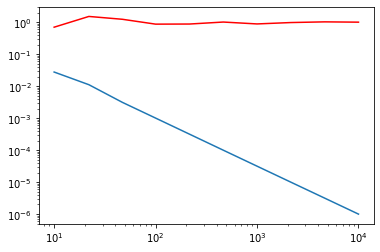

In [ ]:
SIZE = [int(x) for x in np.ceil(10**np.linspace(1,4,10))]
print(SIZE)
diffs = []
mags = []
for sz_idx in SIZE:
    mymat = np.random.randn(sz_idx, sz_idx)
    myvec = np.random.randn(sz_idx)
    diff_mat = 1/sz_idx*np.matmul(mymat.T,mymat) - np.identity(sz_idx)
    diffs.append(1/(sz_idx**2)*np.sqrt(np.dot(diff_mat.flatten(),diff_mat.flatten())))
    mags.append(1/sz_idx * np.dot(myvec, myvec))
    print(1/sz_idx*np.matmul(mymat.T,mymat)[0:5,0:5])
plt.loglog(SIZE, diffs)
plt.loglog(SIZE, mags, 'r')
plt.show()

f( 0 ): [[0.76776444]]
lam( 0 ): [[1.99890333]]
lam/f( 0 ): [[2.60353726]]
f( 1 ): [[1.78906921]]
lam( 1 ): [[4.00069539]]
lam/f( 1 ): [[2.23618817]]
f( 2 ): [[5.41238374]]
lam( 2 ): [[10.11494077]]
lam/f( 2 ): [[1.86885137]]
f( 3 ): [[16.77161895]]
lam( 3 ): [[28.33466532]]
lam/f( 3 ): [[1.68944128]]
f( 4 ): [[53.46330048]]
lam( 4 ): [[84.73774704]]
lam/f( 4 ): [[1.58497037]]
f( 5 ): [[186.35204581]]
lam( 5 ): [[267.45148073]]
lam/f( 5 ): [[1.43519477]]
f( 6 ): [[692.84318869]]
lam( 6 ): [[881.39259124]]
lam/f( 6 ): [[1.27213864]]
f( 7 ): [[2483.33983271]]
lam( 7 ): [[2952.15620754]]
lam/f( 7 ): [[1.18878462]]
f( 8 ): [[9119.37112149]]
lam( 8 ): [[10120.8137296]]
lam/f( 8 ): [[1.10981488]]
f( 9 ): [[33000.91396463]]
lam( 9 ): [[34571.18644687]]
lam/f( 9 ): [[1.0475827]]
f( 10 ): [[121909.20185443]]
lam( 10 ): [[122518.51556594]]
lam/f( 10 ): [[1.00499809]]


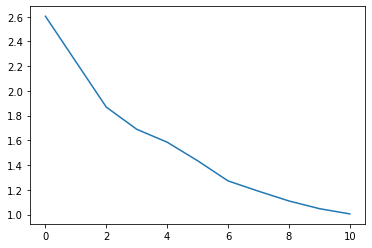

In [ ]:
SIZE = 2**8
TRIALS = 10**3
powers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
g_params = []
for power in powers:
    f_avg = 0
    lam_avg = 0
    for i in range(TRIALS):
        v_vec = np.random.randn(1, SIZE)
        w_mat = np.random.randn(SIZE, SIZE)
        u_vec = np.random.randn(SIZE, 1)
        vw = np.matmul(v_vec, w_mat)
        wTwp = np.identity(SIZE)
        for j in range(power):
            wTwp = np.matmul(wTwp, 1/SIZE * np.matmul(w_mat.T, w_mat))
        
        wu = np.matmul(w_mat, u_vec)
        f = 1/SIZE * np.matmul(np.matmul(vw, wTwp), u_vec)
        lam = 1/(SIZE**2) * (np.matmul(vw, np.matmul(wTwp, vw.T)) + np.matmul(wu.T, np.matmul(w_mat, np.matmul(wTwp, u_vec))))

        f_avg += 1/TRIALS * np.abs(f)
        lam_avg += 1/TRIALS * lam
    
    print('f(', power, '):', f_avg)
    print('lam(', power, '):', lam_avg)
    print('lam/f(', power, '):', lam_avg/f_avg)
    g_params.append((lam_avg/f_avg)[0][0])
    
plt.plot(powers, g_params)
plt.show()
    

#### Old Code

##### NTK Calculation

In [ ]:

def ntk(x, net, lprime, NTRAIN, WIDTH, input_dim, out):

    ntk_val = np.zeros((NTRAIN, NTRAIN))
#     ntk_val_grad = np.zeros((NTRAIN, NTRAIN))
    
    if LENGTH == 1:
        v, u = net.fc_v.weight.data.view(1, WIDTH), net.fc_u.weight.data.view(WIDTH, input_dim)
        
#         v_grads = net.fc_v.weight.grad.view(1, WIDTH)
#         u_grads = net.fc_u.weight.grad.view(WIDTH, input_dim)
    
        for sample1 in range(x.size()[0]): # iterate over batch index
            for sample2 in range(x.size()[0]):
                ux1 = torch.matmul(u, 1/np.sqrt(input_dim) * x[sample1])
                ux2 = torch.matmul(u, 1/np.sqrt(input_dim) * x[sample2])
#                 ux1 = torch.matmul(u, x[sample1])
#                 ux2 = torch.matmul(u, x[sample2])
                au1 = net.act(ux1)
                au2 = net.act(ux2)
                apu1 = actp(ux1)
                apu2 = actp(ux2)
                vup1 = v * apu1
                vup2 = v * apu2
                
#                 print('ux1 term:', ux1[0:10])
#                 print('au term:', au1[0:10])
#                 print('v term:', v[0,0:10])
                
                ntk_val[sample1][sample2] = 1 / WIDTH * (
                    torch.matmul(au1, au2) + torch.matmul(vup1, vup2.transpose(0,1)) * 
                    torch.matmul(1/np.sqrt(input_dim)*x[sample1], 1/np.sqrt(input_dim)*x[sample2]))
                
#                 print('u term:', 1 / WIDTH*torch.matmul(au1, au2))
#                 print('v term:', 1 / WIDTH*torch.matmul(vup1, vup2.transpose(0,1)) * torch.matmul(x[sample1], x[sample2]))
#                 v_grad1 = v_grads/lprime[sample1]
#                 v_grad2 = v_grads/lprime[sample2]
#                 u_grad1 = v_grads/lprime[sample1]
#                 u_grad2 = v_grads/lprime[sample2]
                
#                 ntk_val_grad[sample1][sample2] = torch.sum(v_grad1 * v_grad2) + torch.sum(u_grad1 * u_grad2)
                
#                 print('ntk_val', ntk_val[sample1][sample2])
                
    elif LENGTH == 2:
        v = net.fc_v.weight.data.view(1, WIDTH)
        w = net.fc_w1.weight.data.view(WIDTH, WIDTH)
        u = net.fc_u.weight.data.view(WIDTH, input_dim)
        
#         v_grads = net.fc_v.weight.grad.view(1, WIDTH)
#         w_grads = net.fc_w1.weight.grad.view(WIDTH, WIDTH)
#         u_grads = net.fc_u.weight.grad.view(WIDTH, input_dim)
         
        for sample1 in range(x.size()[0]): 
            for sample2 in range(x.size()[0]):
                ux1 = 1/np.sqrt(input_dim) * torch.matmul(u, x[sample1])
                ux2 = 1/np.sqrt(input_dim) * torch.matmul(u, x[sample2])
                au1 = net.act(ux1) 
                au2 = net.act(ux2)
                apu1 = actp(ux1) 
                apu2 = actp(ux2)
                wu1 = torch.matmul(w, au1) 
                wu2 = torch.matmul(w, au2)
                awu1 = net.act(1/np.sqrt(WIDTH) * wu1)
                awu2 = net.act(1/np.sqrt(WIDTH) * wu2)
                apwu1 = actp(1/np.sqrt(WIDTH) * wu1)
                apwu2 = actp(1/np.sqrt(WIDTH) * wu2)                
                uterm1 = torch.matmul(v * apwu1, w) * apu1 * 1/np.sqrt(input_dim) * x[sample1]
                uterm2 = torch.matmul(v * apwu2, w) * apu2 * 1/np.sqrt(input_dim) * x[sample2]

                v_term = 1/WIDTH * torch.matmul(awu1, awu2)
                w_term = 1 / (WIDTH**2) * torch.matmul((v*apwu1), (v*apwu2).transpose(0,1)) * np.matmul(au1, au2) 
                u_term = 1 / (WIDTH**2) * torch.matmul(uterm1, uterm2.transpose(0,1))

                ntk_val[sample1][sample2] = v_term + w_term + u_term
                
#                 v_grad1 = v_grads/lprime[sample1]
#                 v_grad2 = v_grads/lprime[sample2]
#                 w_grad1 = w_grads/lprime[sample1]
#                 w_grad2 = w_grads/lprime[sample2]
#                 u_grad1 = v_grads/lprime[sample1]
#                 u_grad2 = v_grads/lprime[sample2]
                
#                 ntk_val_grad[sample1][sample2] = (torch.sum(v_grad1 * v_grad2) + torch.sum(w_grad1 * w_grad2) 
#                                                   + torch.sum(u_grad1 * u_grad2))
                
#                 print('ntk_val', ntk_val[sample1][sample2])
#                 print('ntk_val_grad', ntk_val_grad[sample1][sample2])

    elif LENGTH == 3:
        v = net.fc_v.weight.data.view(1, WIDTH)
        w2 = net.fc_w2.weight.data.view(WIDTH, WIDTH)
        w1 = net.fc_w1.weight.data.view(WIDTH, WIDTH)
        u = net.fc_u.weight.data.view(WIDTH, input_dim)
          
        for sample1 in range(x.size()[0]): 
            for sample2 in range(x.size()[0]):
                xt0_1 = 1/np.sqrt(input_dim) * torch.matmul(u, x[sample1])
                xt0_2 = 1/np.sqrt(input_dim) * torch.matmul(u, x[sample2])
                x1_1 = net.act(xt0_1) 
                x1_2 = net.act(xt0_2)
                px1_1 = actp(xt0_1) 
                px1_2 = actp(xt0_2)
                xt1_1 = torch.matmul(1/np.sqrt(WIDTH) * w1, x1_1) 
                xt1_2 = torch.matmul(1/np.sqrt(WIDTH) * w1, x1_2)
                x2_1 = net.act(xt1_1)
                x2_2 = net.act(xt1_2)
                px2_1 = actp(xt1_1)
                px2_2 = actp(xt1_2)
                xt2_1 = torch.matmul(1/np.sqrt(WIDTH) * w2, x2_1) 
                xt2_2 = torch.matmul(1/np.sqrt(WIDTH) * w2, x2_2)
                x3_1 = net.act(xt2_1)
                x3_2 = net.act(xt2_2)
                px3_1 = actp(xt2_1)
                px3_2 = actp(xt2_2)
                
                v_term = 1/(WIDTH) * torch.matmul(x3_1, x3_2)
                w2_term = 1/(WIDTH**2) * torch.matmul(v*px3_1, (v*px3_2).transpose(0,1)) * torch.matmul(x2_1, x2_2)
                w1term1 = torch.matmul(v*px3_1, w2)
                w1term2 = torch.matmul(v*px3_2, w2)
                w1_term = 1/(WIDTH**3) * torch.matmul(w1term1*px2_1, (w1term2*px2_2).transpose(0,1)) * torch.matmul(x1_1, x1_2)
                uterm1 = torch.matmul(torch.matmul(v*px3_1, w2)*px2_1, w1)
                uterm2 = torch.matmul(torch.matmul(v*px3_2, w2)*px2_2, w1)
                u_term = 1/(WIDTH**3) * torch.matmul(uterm1*px1_1, (uterm2*px1_2).transpose(0,1)) * (
                    1/np.sqrt(input_dim)*x[sample1]*1/np.sqrt(input_dim)*x[sample2])
                
                ntk_val[sample1][sample2] = v_term + w2_term + w1_term + u_term 

    # Normalize by number of samples and input dimension
    ntk_val = 1/NTRAIN * ntk_val
                    
    print('ntk_val manual:', ntk_val) 
#     print('ntk_val_grad', ntk_val_grad)
        
    return ntk_val

##### Confirmation of 2-Sample Cross-Entropy Loss

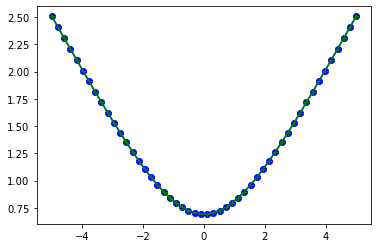

In [ ]:
x_nums = np.linspace(-5, 5, 50)
y_nums = 1/2 * (np.log(1+np.exp(x_nums))+np.log(1+np.exp(-x_nums)))
X = torch.tensor([[1.0],[1.0]]).view(2,1)
y = torch.tensor([1, 0]).view(2)
y_torch = []
with torch.no_grad():
    for f in x_nums:
        little_l = torch.tensor([[0.0],[0.0],[0.0],[0.0]]).view(2,2)
        for sample in range(X.size()[0]):
              little_l[sample][:] = torch.tensor([f*X[sample]/2,-f*X[sample]/2]).view(1,2)
        loss = F.cross_entropy(little_l, y)
        y_torch.append(loss.data.numpy())
plt.figure
plt.plot(x_nums, y_nums,'b-o')
plt.plot(x_nums, y_torch,'g-+')
plt.show()

##### Other Functions

In [ ]:
def actp(x):
    if ACT == 'Linear':
        return torch.ones(x.size())
    elif ACT == 'ReLU':
        return 1/2 * (torch.sign(x) + 1)
    elif ACT == 'Tanh':	
        return 1-(torch.tanh(x))**2